In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelBinarizer

import shap

import xgboost
import catboost

plt.rcParams['figure.figsize'] = [15, 8]

# Data exploration

In [2]:
train = pd.read_csv('Exercise_train (2).csv')
holdout = pd.read_csv('Exercise_test (2).csv')

In [3]:
# Looks like we have the same columns
set(train.columns.to_list()).difference(set(holdout.columns.to_list()))

set()

In [4]:
# Let's have a look at the data
train.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2225,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,1598,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,7896,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,1458,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,1817,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [5]:
col_mapping = {col: 'col_%s' % ind for (ind, col) in enumerate(train.columns) if col != 'poor'}

In [6]:
col_mapping

{'Unnamed: 0': 'col_0',
 'id': 'col_1',
 'kjkrfgld': 'col_2',
 'bpowgknt': 'col_3',
 'raksnhjf': 'col_4',
 'vwpsxrgk': 'col_5',
 'omtioxzz': 'col_6',
 'yfmzwkru': 'col_7',
 'tiwrsloh': 'col_8',
 'weioazcf': 'col_9'}

In [7]:
# Tough column names, let's rename them (except what we have to predict)
train.rename(columns={col: 'col_%s' % ind 
                      for (ind, col) in enumerate(train.columns) if col != 'poor'}, inplace=True)
holdout.rename(columns={col: 'col_%s' % ind 
                     for (ind, col) in enumerate(holdout.columns) if col != 'poor'}, inplace=True)

In [8]:
train.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,poor
0,2225,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,1598,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,7896,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,1458,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,1817,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [9]:
categorical_cols = [col for col, col_type in zip(train.columns, train.dtypes) if col_type == 'object']
categorical_cols

['col_2', 'col_3', 'col_4', 'col_5']

In [10]:
train[categorical_cols[0]]

0       KfoTG
1       ljBjd
2       Lsuai
3       KfoTG
4       KfoTG
        ...  
6557    KfoTG
6558    qzGkS
6559    KfoTG
6560    Lsuai
6561    qzGkS
Name: col_2, Length: 6562, dtype: object

In [11]:
train.describe()

,col_0,col_1,col_6,col_7,col_8,col_9
count,6562.000000,6562.000000,6361.000000,6353.000000,6355.000000,6366.000000
mean,4113.757543,49752.631058,17.455117,-2.826696,-4.194335,-7.461828
std,2353.382080,28800.799597,10.924393,12.615775,4.476410,11.198626
min,0.000000,14.000000,-127.000000,-4.000000,-31.000000,-74.500000
25%,2088.500000,25004.500000,12.000000,-4.000000,-7.000000,-14.500000
50%,4115.500000,49598.500000,12.000000,-3.000000,-3.000000,-4.500000
75%,6156.750000,74268.500000,21.000000,-2.000000,-1.000000,0.500000
max,8202.000000,99965.000000,111.000000,1000.000000,3.000000,10.500000


In [12]:
train.shape[0]

6562

In [13]:
holdout.shape[0]

1641

In [14]:
train.shape[0] / (train.shape[0] + holdout.shape[0])

0.7999512373521882

##  Let's "visually" look at the column distributions


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


array([[<AxesSubplot:title={'center':'col_0'}>,
        <AxesSubplot:title={'center':'col_1'}>],
       [<AxesSubplot:title={'center':'col_6'}>,
        <AxesSubplot:title={'center':'col_7'}>],
       [<AxesSubplot:title={'center':'col_8'}>,
        <AxesSubplot:title={'center':'col_9'}>]], dtype=object)

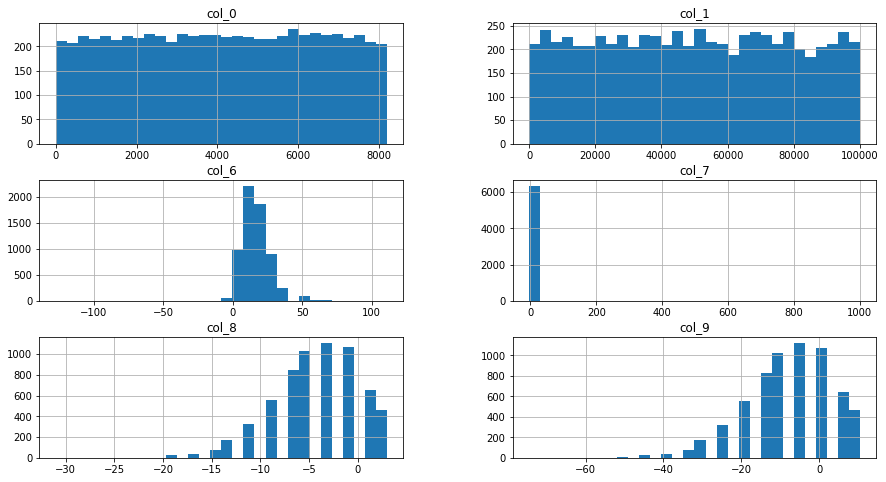

In [15]:
train.hist(bins=30)

In [16]:
cols = [col for col in train.columns if col != 'poor']
nulls = train[cols].isnull().sum()/ train.shape[0]
print(nulls)

holdout[cols].isnull().sum()/ holdout.shape[0]

col_0    0.000000
col_1    0.000000
col_2    0.029869
col_3    0.031240
col_4    0.027583
col_5    0.030174
col_6    0.030631
col_7    0.031850
col_8    0.031545
col_9    0.029869
dtype: float64


col_0    0.000000
col_1    0.000000
col_2    0.028032
col_3    0.029860
col_4    0.021938
col_5    0.027422
col_6    0.032907
col_7    0.026813
col_8    0.024375
col_9    0.037782
dtype: float64

In [17]:
print(nulls.mean())
1 - len(cols) * nulls.mean()

0.02427613532459616


0.7572386467540384

In [18]:
train.shape

(6562, 11)

In [19]:
print(train.dropna().shape[0] / train.shape[0])
print(holdout.dropna().shape[0] / holdout.shape[0])

0.7820786345626334
0.7891529555149299


## It looks like
* Roughly 3% of the variables of each column are null.
* This distribution is the same across train and holdout data
* these nulls evenly distributed across rows (otherwise we'd have # nulls != len(cols) * nulls.mean()
* For that reason, we're going to drop those nulls altogether
* col_7 has extreme values
* **col_1** and **col_2** have very similar distributions
* **col_8** and **col_9** too have very similar distributions

Let's look deeper into these issues

In [20]:
train.dropna(inplace=True)
holdout.dropna(inplace=True)

### Let's explore deeper into col_7

-3.0       2078
-4.0       1652
-2.0       1111
-1.0        259
 0.0         23
 1.0          8
 1000.0       1
Name: col_7, dtype: int64


<AxesSubplot:>

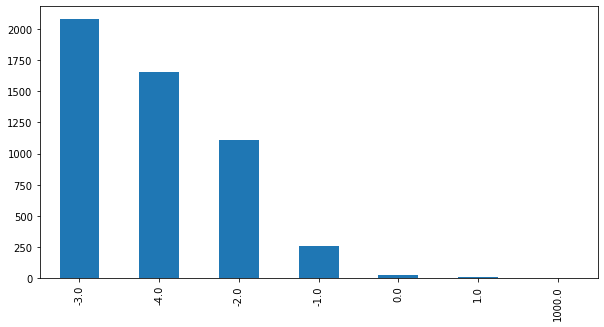

In [21]:
print(train.col_7.value_counts())
train['col_7'].value_counts().plot.bar(figsize=[10,5])

We've got an _outlier_ at **col_7**, that may mess with the model. Let's keep it in mind and see if we need to drop it afterwards

In [22]:
train.col_8.corr(train.col_9)

0.9999999999999984

In [23]:
train.col_0.corr(train.col_1)

0.0051646762282353716

<AxesSubplot:xlabel='col_0', ylabel='col_1'>

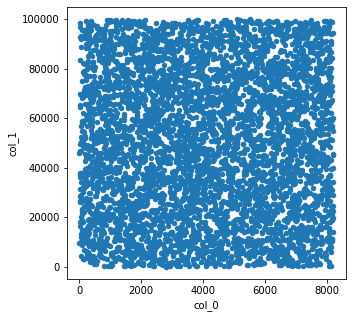

In [24]:
train.plot.scatter(x='col_0', y='col_1', figsize=[5,5])

In [25]:
train.col_0.value_counts().sort_values(ascending=False)

0       1
488     1
6147    1
8196    1
2053    1
       ..
4090    1
6141    1
2027    1
1983    1
2047    1
Name: col_0, Length: 5132, dtype: int64

In [26]:
holdout.col_0.value_counts().sort_values(ascending=False)

6144    1
126     1
6146    1
3       1
2054    1
       ..
2041    1
2043    1
8188    1
511     1
8190    1
Name: col_0, Length: 1295, dtype: int64

In [27]:
train.col_1.value_counts().sort_values(ascending=False)

67585    1
66048    1
97056    1
42916    1
26633    1
        ..
23183    1
4094     1
73712    1
63417    1
10239    1
Name: col_1, Length: 5132, dtype: int64

In [28]:
holdout.col_1.value_counts().sort_values(ascending=False)

73730    1
2168     1
32772    1
51205    1
86022    1
        ..
65531    1
8188     1
94147    1
14324    1
24575    1
Name: col_1, Length: 1295, dtype: int64

<AxesSubplot:xlabel='col_8', ylabel='col_9'>

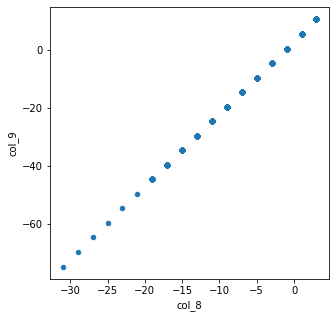

In [29]:
train.plot.scatter(x='col_8', y='col_9', figsize=[5,5])

### We've got that
* col_0 and col_1 are some sort of unique identifiers, so we **cannot use them in the model**.
* col_8 and col_9 are almost perfectly **linearly correlated**. 

This may have implications depending on the model

In [30]:
train.drop(['col_0', 'col_1'], axis=1, inplace=True)
holdout.drop(['col_0', 'col_1'], axis=1, inplace=True)

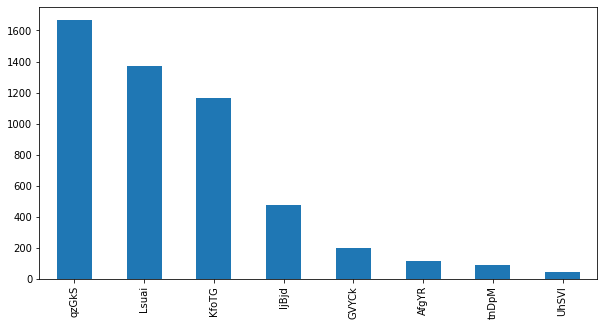

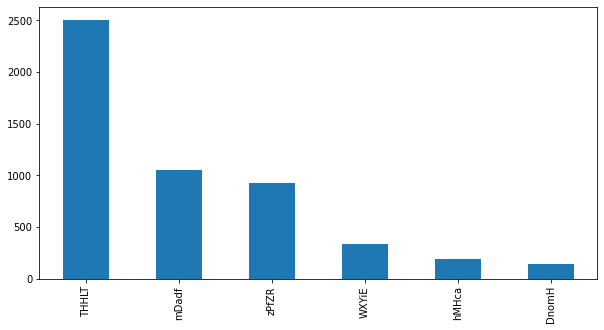

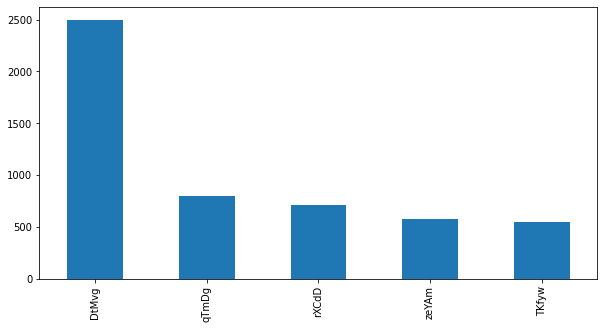

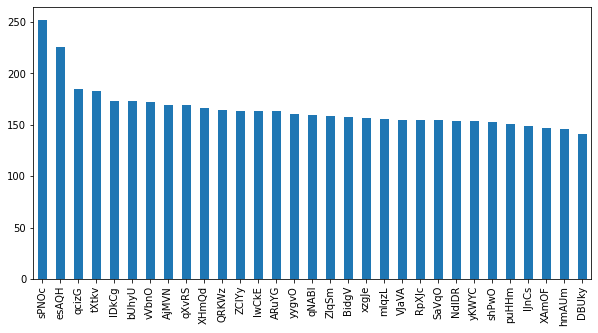

In [31]:
for col in categorical_cols:
    plt.figure()
    train[col].value_counts().plot.bar(figsize=[10, 5])

### Poverty variable seems pretty balanced
No rebalancing may be necessary

In [32]:
train.poor.value_counts() / train.poor.count()

False    0.549883
True     0.450117
Name: poor, dtype: float64

In [33]:
holdout.poor.value_counts() / holdout.poor.count()

False    0.534363
True     0.465637
Name: poor, dtype: float64

# Data preprocessing

## One-hot encoding of categorical variables.
In order to input the variables into the model, we need to encode categorical variables

In [36]:
def encode_variables(dataframe, encoders=None):
    '''Return the encoded version of the dataframe.
    '''
    # This is only done here for the convenience of being able to rerun the functions.
    # This copies can be costly in production
    dataframe = dataframe.copy(deep=True)
    encoder_dict = {}
    encoded_list = []
    for cat in categorical_cols:
        if encoders is not None:
            encoder = encoders[cat]
        else:
            encoder = LabelBinarizer()
            encoder.fit(dataframe[cat].values.tolist())
        encoded = pd.DataFrame(encoder.transform(dataframe[cat].values.tolist()),
                               columns=['%s_%s' % (cat, label) for label in encoder.classes_])
        encoder_dict[cat] = encoder
        encoded_list.append(encoded)
        dataframe.drop(cat, axis=1, inplace=True)

    all_encoded = pd.concat(encoded_list, axis=1)

    all_encoded.reset_index(drop=True, inplace=True)
    dataframe.reset_index(drop=True, inplace=True)
    all_data = pd.concat([all_encoded, dataframe], axis=1)

    return encoder_dict, all_data


In [38]:
# Let's encode all the dataset just in case some appearences are not in both datasets
encoder, _ = encode_variables(pd.concat([train, holdout], axis=0))
_, train_encoded = encode_variables(train, encoder)
_, holdout_encoded = encode_variables(holdout, encoder)

In [39]:
encoder['col_2'].transform(['ljBjd'])[0]

array([0, 0, 0, 0, 0, 1, 0, 0])

In [40]:
train_encoded.head()

,col_2_AfgYR,col_2_GVYCk,col_2_KfoTG,col_2_Lsuai,col_2_UhSVl,col_2_ljBjd,col_2_qzGkS,col_2_tnDpM,col_3_DnomH,col_3_THHLT,...,col_5_tXtkv,col_5_vVbnO,col_5_xzgJe,col_5_yKWYC,col_5_yygvO,col_6,col_7,col_8,col_9,poor
0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,21.0,-2.0,-5.0,-9.5,True
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,12.0,-3.0,-5.0,-9.5,True
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,12.0,-1.0,-5.0,-9.5,False
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,21.0,-4.0,-5.0,-9.5,True
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,12.0,-3.0,-3.0,-4.5,True


In [44]:
corrs = train_encoded.corr()

In [48]:
fig = px.imshow(corrs, width=800, height=800)
fig.show()

## Let's split the dataset
The approach will be the following:
* We'll keep the provided data as "holdout", 
* train with most part of the "train" data, and evaluate with a small part of the train data
* evaluate final performance of the model with "test" data

In [42]:
train_df, test_df = train_test_split(train_encoded, train_size=0.8, random_state=7)

In [43]:
explanatory_variables = [col for col in train_encoded.columns if col != 'poor']
X_train = train_df[explanatory_variables]
y_train = train_df['poor'].astype(int)

X_test = test_df[explanatory_variables]
y_test = test_df['poor'].astype(int)

X_holdout = holdout_encoded[explanatory_variables]
y_holdout = holdout_encoded['poor'].astype(int)

## Model tuning

In [49]:
cbc = catboost.CatBoostClassifier(
    thread_count=4,
    save_snapshot=False,
    random_seed=7,
    learning_rate=0.05,
)

In [50]:
param_grid = {  
    'depth': [2, 4, 6, 8, 10, 12],
    'l2_leaf_reg': [0, 1, 3, 5, 7, 9],
    'iterations': [100, 200]
}

In [51]:
data = catboost.Pool(data=X_train, label=y_train)

In [52]:
grid_search_result = cbc.grid_search(
    X=data, 
    param_grid=param_grid,
    cv=10,
    plot=True,
    shuffle=True,
    train_size=0.8,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6848028	test: 0.6857044	best: 0.6857044 (0)	total: 49.1ms	remaining: 4.86s
1:	learn: 0.6773239	test: 0.6790771	best: 0.6790771 (1)	total: 50.6ms	remaining: 2.48s
2:	learn: 0.6706225	test: 0.6731799	best: 0.6731799 (2)	total: 51.9ms	remaining: 1.68s
3:	learn: 0.6649471	test: 0.6677247	best: 0.6677247 (3)	total: 53.3ms	remaining: 1.28s
4:	learn: 0.6582947	test: 0.6608374	best: 0.6608374 (4)	total: 54.8ms	remaining: 1.04s
5:	learn: 0.6523409	test: 0.6546756	best: 0.6546756 (5)	total: 56.4ms	remaining: 884ms
6:	learn: 0.6479917	test: 0.6504550	best: 0.6504550 (6)	total: 58.1ms	remaining: 772ms
7:	learn: 0.6430094	test: 0.6452823	best: 0.6452823 (7)	total: 59.6ms	remaining: 685ms
8:	learn: 0.6387079	test: 0.6415724	best: 0.6415724 (8)	total: 61.1ms	remaining: 617ms
9:	learn: 0.6342228	test: 0.6376907	best: 0.6376907 (9)	total: 62.5ms	remaining: 562ms
10:	learn: 0.6304721	test: 0.6341554	best: 0.6341554 (10)	total: 63.8ms	remaining: 516ms
11:	learn: 0.6262947	test: 0.6300992	best

56:	learn: 0.5519141	test: 0.5613443	best: 0.5613443 (56)	total: 52.9ms	remaining: 39.9ms
57:	learn: 0.5508136	test: 0.5601302	best: 0.5601302 (57)	total: 55.9ms	remaining: 40.5ms
58:	learn: 0.5499959	test: 0.5589111	best: 0.5589111 (58)	total: 58.6ms	remaining: 40.7ms
59:	learn: 0.5490639	test: 0.5579139	best: 0.5579139 (59)	total: 60.3ms	remaining: 40.2ms
60:	learn: 0.5479670	test: 0.5568885	best: 0.5568885 (60)	total: 61.6ms	remaining: 39.4ms
61:	learn: 0.5470222	test: 0.5561069	best: 0.5561069 (61)	total: 63.1ms	remaining: 38.7ms
62:	learn: 0.5459108	test: 0.5554697	best: 0.5554697 (62)	total: 64.6ms	remaining: 37.9ms
63:	learn: 0.5450599	test: 0.5543297	best: 0.5543297 (63)	total: 66.2ms	remaining: 37.2ms
64:	learn: 0.5442735	test: 0.5539722	best: 0.5539722 (64)	total: 67.7ms	remaining: 36.4ms
65:	learn: 0.5435718	test: 0.5528946	best: 0.5528946 (65)	total: 69.1ms	remaining: 35.6ms
66:	learn: 0.5427323	test: 0.5524457	best: 0.5524457 (66)	total: 70.6ms	remaining: 34.8ms
67:	learn:

13:	learn: 0.6191433	test: 0.6249059	best: 0.6249059 (13)	total: 13.6ms	remaining: 83.5ms
14:	learn: 0.6163197	test: 0.6224265	best: 0.6224265 (14)	total: 15ms	remaining: 84.8ms
15:	learn: 0.6132928	test: 0.6198835	best: 0.6198835 (15)	total: 17.3ms	remaining: 90.7ms
16:	learn: 0.6105129	test: 0.6173266	best: 0.6173266 (16)	total: 18.3ms	remaining: 89.3ms
17:	learn: 0.6084178	test: 0.6156972	best: 0.6156972 (17)	total: 19.3ms	remaining: 87.7ms
18:	learn: 0.6058847	test: 0.6133543	best: 0.6133543 (18)	total: 20.2ms	remaining: 86.2ms
19:	learn: 0.6033024	test: 0.6115323	best: 0.6115323 (19)	total: 21.1ms	remaining: 84.6ms
20:	learn: 0.6017699	test: 0.6104577	best: 0.6104577 (20)	total: 22ms	remaining: 82.9ms
21:	learn: 0.5993829	test: 0.6076028	best: 0.6076028 (21)	total: 22.9ms	remaining: 81.1ms
22:	learn: 0.5978533	test: 0.6060938	best: 0.6060938 (22)	total: 23.7ms	remaining: 79.4ms
23:	learn: 0.5961566	test: 0.6042113	best: 0.6042113 (23)	total: 24.6ms	remaining: 77.9ms
24:	learn: 0.5

2:	learn: 0.6694617	test: 0.6708043	best: 0.6708043 (2)	total: 3.4ms	remaining: 110ms
3:	learn: 0.6630925	test: 0.6652408	best: 0.6652408 (3)	total: 4.7ms	remaining: 113ms
4:	learn: 0.6566879	test: 0.6589404	best: 0.6589404 (4)	total: 5.81ms	remaining: 110ms
5:	learn: 0.6508676	test: 0.6540572	best: 0.6540572 (5)	total: 6.91ms	remaining: 108ms
6:	learn: 0.6456630	test: 0.6486951	best: 0.6486951 (6)	total: 7.75ms	remaining: 103ms
7:	learn: 0.6419615	test: 0.6454980	best: 0.6454980 (7)	total: 8.7ms	remaining: 100ms
8:	learn: 0.6379929	test: 0.6414884	best: 0.6414884 (8)	total: 9.58ms	remaining: 96.9ms
9:	learn: 0.6338458	test: 0.6380099	best: 0.6380099 (9)	total: 10.5ms	remaining: 94.2ms
10:	learn: 0.6311283	test: 0.6351985	best: 0.6351985 (10)	total: 11.3ms	remaining: 91.2ms
11:	learn: 0.6268885	test: 0.6310942	best: 0.6310942 (11)	total: 12.1ms	remaining: 88.9ms
12:	learn: 0.6240414	test: 0.6287413	best: 0.6287413 (12)	total: 13ms	remaining: 87.1ms
13:	learn: 0.6209895	test: 0.6251974	

88:	learn: 0.5265103	test: 0.5374083	best: 0.5374083 (88)	total: 88.6ms	remaining: 110ms
89:	learn: 0.5258709	test: 0.5368409	best: 0.5368409 (89)	total: 90.2ms	remaining: 110ms
90:	learn: 0.5255304	test: 0.5364156	best: 0.5364156 (90)	total: 91.8ms	remaining: 110ms
91:	learn: 0.5249982	test: 0.5357688	best: 0.5357688 (91)	total: 93ms	remaining: 109ms
92:	learn: 0.5245145	test: 0.5352654	best: 0.5352654 (92)	total: 94.3ms	remaining: 109ms
93:	learn: 0.5240406	test: 0.5352615	best: 0.5352615 (93)	total: 95.3ms	remaining: 108ms
94:	learn: 0.5234101	test: 0.5346932	best: 0.5346932 (94)	total: 96.3ms	remaining: 106ms
95:	learn: 0.5230869	test: 0.5347546	best: 0.5346932 (94)	total: 97.2ms	remaining: 105ms
96:	learn: 0.5226198	test: 0.5340149	best: 0.5340149 (96)	total: 98.1ms	remaining: 104ms
97:	learn: 0.5220133	test: 0.5332289	best: 0.5332289 (97)	total: 99ms	remaining: 103ms
98:	learn: 0.5215218	test: 0.5326860	best: 0.5326860 (98)	total: 99.9ms	remaining: 102ms
99:	learn: 0.5212046	test

68:	learn: 0.5403829	test: 0.5495228	best: 0.5495228 (68)	total: 81.3ms	remaining: 154ms
69:	learn: 0.5394847	test: 0.5489253	best: 0.5489253 (69)	total: 82.7ms	remaining: 154ms
70:	learn: 0.5388063	test: 0.5487874	best: 0.5487874 (70)	total: 84.1ms	remaining: 153ms
71:	learn: 0.5378969	test: 0.5482373	best: 0.5482373 (71)	total: 85.7ms	remaining: 152ms
72:	learn: 0.5372483	test: 0.5474878	best: 0.5474878 (72)	total: 87.2ms	remaining: 152ms
73:	learn: 0.5363859	test: 0.5470567	best: 0.5470567 (73)	total: 88.8ms	remaining: 151ms
74:	learn: 0.5357147	test: 0.5461029	best: 0.5461029 (74)	total: 90.4ms	remaining: 151ms
75:	learn: 0.5349085	test: 0.5451306	best: 0.5451306 (75)	total: 91.8ms	remaining: 150ms
76:	learn: 0.5341739	test: 0.5445240	best: 0.5445240 (76)	total: 93.3ms	remaining: 149ms
77:	learn: 0.5335127	test: 0.5439833	best: 0.5439833 (77)	total: 94.7ms	remaining: 148ms
78:	learn: 0.5327954	test: 0.5434668	best: 0.5434668 (78)	total: 96.1ms	remaining: 147ms
79:	learn: 0.5319977	

189:	learn: 0.4896385	test: 0.5020378	best: 0.5020378 (189)	total: 274ms	remaining: 14.4ms
190:	learn: 0.4894556	test: 0.5017073	best: 0.5017073 (190)	total: 279ms	remaining: 13.2ms
191:	learn: 0.4892288	test: 0.5015645	best: 0.5015645 (191)	total: 282ms	remaining: 11.7ms
192:	learn: 0.4890117	test: 0.5013602	best: 0.5013602 (192)	total: 286ms	remaining: 10.4ms
193:	learn: 0.4887320	test: 0.5011724	best: 0.5011724 (193)	total: 292ms	remaining: 9.04ms
194:	learn: 0.4885663	test: 0.5010496	best: 0.5010496 (194)	total: 294ms	remaining: 7.53ms
195:	learn: 0.4883393	test: 0.5008010	best: 0.5008010 (195)	total: 295ms	remaining: 6.03ms
196:	learn: 0.4881221	test: 0.5004789	best: 0.5004789 (196)	total: 297ms	remaining: 4.52ms
197:	learn: 0.4878779	test: 0.5001556	best: 0.5001556 (197)	total: 300ms	remaining: 3.02ms
198:	learn: 0.4876044	test: 0.5001635	best: 0.5001556 (197)	total: 302ms	remaining: 1.52ms
199:	learn: 0.4874234	test: 0.4997153	best: 0.4997153 (199)	total: 304ms	remaining: 0us

b

91:	learn: 0.5253966	test: 0.5366576	best: 0.5366576 (91)	total: 154ms	remaining: 181ms
92:	learn: 0.5252022	test: 0.5365428	best: 0.5365428 (92)	total: 156ms	remaining: 179ms
93:	learn: 0.5245726	test: 0.5360933	best: 0.5360933 (93)	total: 159ms	remaining: 179ms
94:	learn: 0.5240677	test: 0.5352637	best: 0.5352637 (94)	total: 160ms	remaining: 177ms
95:	learn: 0.5234105	test: 0.5348512	best: 0.5348512 (95)	total: 167ms	remaining: 181ms
96:	learn: 0.5227083	test: 0.5344968	best: 0.5344968 (96)	total: 170ms	remaining: 180ms
97:	learn: 0.5222280	test: 0.5338560	best: 0.5338560 (97)	total: 171ms	remaining: 178ms
98:	learn: 0.5216032	test: 0.5330295	best: 0.5330295 (98)	total: 173ms	remaining: 176ms
99:	learn: 0.5209946	test: 0.5325151	best: 0.5325151 (99)	total: 174ms	remaining: 174ms
100:	learn: 0.5202805	test: 0.5319245	best: 0.5319245 (100)	total: 176ms	remaining: 172ms
101:	learn: 0.5195873	test: 0.5317858	best: 0.5317858 (101)	total: 177ms	remaining: 170ms
102:	learn: 0.5191276	test: 

2:	learn: 0.6694539	test: 0.6707966	best: 0.6707966 (2)	total: 4.97ms	remaining: 327ms
3:	learn: 0.6626075	test: 0.6649063	best: 0.6649063 (3)	total: 7.26ms	remaining: 356ms
4:	learn: 0.6564919	test: 0.6589104	best: 0.6589104 (4)	total: 8.17ms	remaining: 319ms
5:	learn: 0.6508813	test: 0.6540766	best: 0.6540766 (5)	total: 9.07ms	remaining: 293ms
6:	learn: 0.6457532	test: 0.6489068	best: 0.6489068 (6)	total: 22.6ms	remaining: 623ms
7:	learn: 0.6421284	test: 0.6457736	best: 0.6457736 (7)	total: 24.9ms	remaining: 597ms
8:	learn: 0.6381023	test: 0.6416613	best: 0.6416613 (8)	total: 25.9ms	remaining: 550ms
9:	learn: 0.6338291	test: 0.6372296	best: 0.6372296 (9)	total: 28.4ms	remaining: 540ms
10:	learn: 0.6300342	test: 0.6344122	best: 0.6344122 (10)	total: 30.6ms	remaining: 526ms
11:	learn: 0.6261515	test: 0.6311288	best: 0.6311288 (11)	total: 32.7ms	remaining: 512ms
12:	learn: 0.6224267	test: 0.6282649	best: 0.6282649 (12)	total: 34.4ms	remaining: 494ms
13:	learn: 0.6191433	test: 0.6249059	

124:	learn: 0.5099912	test: 0.5211321	best: 0.5211321 (124)	total: 197ms	remaining: 118ms
125:	learn: 0.5094766	test: 0.5208180	best: 0.5208180 (125)	total: 202ms	remaining: 118ms
126:	learn: 0.5091158	test: 0.5204239	best: 0.5204239 (126)	total: 207ms	remaining: 119ms
127:	learn: 0.5086280	test: 0.5199498	best: 0.5199498 (127)	total: 209ms	remaining: 117ms
128:	learn: 0.5082977	test: 0.5198965	best: 0.5198965 (128)	total: 210ms	remaining: 116ms
129:	learn: 0.5079744	test: 0.5195054	best: 0.5195054 (129)	total: 212ms	remaining: 114ms
130:	learn: 0.5077882	test: 0.5191893	best: 0.5191893 (130)	total: 214ms	remaining: 112ms
131:	learn: 0.5073925	test: 0.5187539	best: 0.5187539 (131)	total: 215ms	remaining: 111ms
132:	learn: 0.5071200	test: 0.5180891	best: 0.5180891 (132)	total: 216ms	remaining: 109ms
133:	learn: 0.5066625	test: 0.5178980	best: 0.5178980 (133)	total: 222ms	remaining: 109ms
134:	learn: 0.5062563	test: 0.5173596	best: 0.5173596 (134)	total: 223ms	remaining: 108ms
135:	learn

74:	learn: 0.5368833	test: 0.5470741	best: 0.5470741 (74)	total: 92.9ms	remaining: 155ms
75:	learn: 0.5360495	test: 0.5463180	best: 0.5463180 (75)	total: 96.1ms	remaining: 157ms
76:	learn: 0.5352357	test: 0.5455642	best: 0.5455642 (76)	total: 100ms	remaining: 160ms
77:	learn: 0.5345784	test: 0.5449060	best: 0.5449060 (77)	total: 102ms	remaining: 159ms
78:	learn: 0.5339296	test: 0.5439472	best: 0.5439472 (78)	total: 104ms	remaining: 159ms
79:	learn: 0.5330585	test: 0.5428821	best: 0.5428821 (79)	total: 105ms	remaining: 158ms
80:	learn: 0.5325983	test: 0.5422253	best: 0.5422253 (80)	total: 107ms	remaining: 157ms
81:	learn: 0.5319093	test: 0.5414117	best: 0.5414117 (81)	total: 108ms	remaining: 156ms
82:	learn: 0.5311803	test: 0.5407873	best: 0.5407873 (82)	total: 110ms	remaining: 155ms
83:	learn: 0.5306063	test: 0.5404368	best: 0.5404368 (83)	total: 111ms	remaining: 154ms
84:	learn: 0.5299473	test: 0.5401492	best: 0.5401492 (84)	total: 114ms	remaining: 154ms
85:	learn: 0.5294194	test: 0.5

31:	learn: 0.5816146	test: 0.5901986	best: 0.5901986 (31)	total: 31.1ms	remaining: 163ms
32:	learn: 0.5801408	test: 0.5894623	best: 0.5894623 (32)	total: 32.4ms	remaining: 164ms
33:	learn: 0.5787162	test: 0.5884116	best: 0.5884116 (33)	total: 33.9ms	remaining: 165ms
34:	learn: 0.5777695	test: 0.5872553	best: 0.5872553 (34)	total: 34.9ms	remaining: 164ms
35:	learn: 0.5766295	test: 0.5862708	best: 0.5862708 (35)	total: 35.9ms	remaining: 163ms
36:	learn: 0.5751507	test: 0.5850179	best: 0.5850179 (36)	total: 36.9ms	remaining: 163ms
37:	learn: 0.5739622	test: 0.5841650	best: 0.5841650 (37)	total: 37.8ms	remaining: 161ms
38:	learn: 0.5727945	test: 0.5827114	best: 0.5827114 (38)	total: 38.8ms	remaining: 160ms
39:	learn: 0.5715178	test: 0.5817071	best: 0.5817071 (39)	total: 39.8ms	remaining: 159ms
40:	learn: 0.5702338	test: 0.5809333	best: 0.5809333 (40)	total: 40.8ms	remaining: 158ms
41:	learn: 0.5691657	test: 0.5801616	best: 0.5801616 (41)	total: 41.7ms	remaining: 157ms
42:	learn: 0.5679995	

186:	learn: 0.4910757	test: 0.5035742	best: 0.5035742 (186)	total: 225ms	remaining: 15.7ms
187:	learn: 0.4909362	test: 0.5036110	best: 0.5035742 (186)	total: 227ms	remaining: 14.5ms
188:	learn: 0.4907169	test: 0.5034570	best: 0.5034570 (188)	total: 230ms	remaining: 13.4ms
189:	learn: 0.4905017	test: 0.5030646	best: 0.5030646 (189)	total: 231ms	remaining: 12.1ms
190:	learn: 0.4903217	test: 0.5026666	best: 0.5026666 (190)	total: 232ms	remaining: 10.9ms
191:	learn: 0.4900486	test: 0.5024760	best: 0.5024760 (191)	total: 233ms	remaining: 9.7ms
192:	learn: 0.4896968	test: 0.5022682	best: 0.5022682 (192)	total: 234ms	remaining: 8.48ms
193:	learn: 0.4894725	test: 0.5020341	best: 0.5020341 (193)	total: 235ms	remaining: 7.26ms
194:	learn: 0.4890840	test: 0.5017707	best: 0.5017707 (194)	total: 236ms	remaining: 6.05ms
195:	learn: 0.4888985	test: 0.5013087	best: 0.5013087 (195)	total: 237ms	remaining: 4.83ms
196:	learn: 0.4886562	test: 0.5007667	best: 0.5007667 (196)	total: 238ms	remaining: 3.62ms


31:	learn: 0.5438143	test: 0.5545955	best: 0.5545955 (31)	total: 61.4ms	remaining: 130ms
32:	learn: 0.5415924	test: 0.5525231	best: 0.5525231 (32)	total: 64.5ms	remaining: 131ms
33:	learn: 0.5394134	test: 0.5507435	best: 0.5507435 (33)	total: 65.7ms	remaining: 128ms
34:	learn: 0.5374894	test: 0.5487905	best: 0.5487905 (34)	total: 67.5ms	remaining: 125ms
35:	learn: 0.5356952	test: 0.5480959	best: 0.5480959 (35)	total: 69ms	remaining: 123ms
36:	learn: 0.5336098	test: 0.5460976	best: 0.5460976 (36)	total: 70.2ms	remaining: 120ms
37:	learn: 0.5318730	test: 0.5443869	best: 0.5443869 (37)	total: 71.2ms	remaining: 116ms
38:	learn: 0.5301492	test: 0.5434882	best: 0.5434882 (38)	total: 72.5ms	remaining: 113ms
39:	learn: 0.5285857	test: 0.5422063	best: 0.5422063 (39)	total: 75.1ms	remaining: 113ms
40:	learn: 0.5268291	test: 0.5407299	best: 0.5407299 (40)	total: 77.8ms	remaining: 112ms
41:	learn: 0.5253510	test: 0.5391977	best: 0.5391977 (41)	total: 79.7ms	remaining: 110ms
42:	learn: 0.5240601	te

81:	learn: 0.4901138	test: 0.5108516	best: 0.5108516 (81)	total: 93.6ms	remaining: 20.6ms
82:	learn: 0.4898405	test: 0.5106254	best: 0.5106254 (82)	total: 95.8ms	remaining: 19.6ms
83:	learn: 0.4889964	test: 0.5101265	best: 0.5101265 (83)	total: 97.8ms	remaining: 18.6ms
84:	learn: 0.4886273	test: 0.5097378	best: 0.5097378 (84)	total: 99.1ms	remaining: 17.5ms
85:	learn: 0.4882035	test: 0.5092312	best: 0.5092312 (85)	total: 100ms	remaining: 16.3ms
86:	learn: 0.4875754	test: 0.5085453	best: 0.5085453 (86)	total: 101ms	remaining: 15.2ms
87:	learn: 0.4872177	test: 0.5079968	best: 0.5079968 (87)	total: 103ms	remaining: 14ms
88:	learn: 0.4865466	test: 0.5079325	best: 0.5079325 (88)	total: 104ms	remaining: 12.8ms
89:	learn: 0.4859572	test: 0.5071192	best: 0.5071192 (89)	total: 105ms	remaining: 11.7ms
90:	learn: 0.4852316	test: 0.5067623	best: 0.5067623 (90)	total: 107ms	remaining: 10.6ms
91:	learn: 0.4847523	test: 0.5060647	best: 0.5060647 (91)	total: 109ms	remaining: 9.44ms
92:	learn: 0.484111

41:	learn: 0.5303116	test: 0.5445765	best: 0.5445765 (41)	total: 47.2ms	remaining: 65.2ms
42:	learn: 0.5287823	test: 0.5433000	best: 0.5433000 (42)	total: 49.8ms	remaining: 66ms
43:	learn: 0.5274928	test: 0.5426727	best: 0.5426727 (43)	total: 50.9ms	remaining: 64.8ms
44:	learn: 0.5257769	test: 0.5408336	best: 0.5408336 (44)	total: 52ms	remaining: 63.6ms
45:	learn: 0.5243639	test: 0.5400970	best: 0.5400970 (45)	total: 53.1ms	remaining: 62.4ms
46:	learn: 0.5228053	test: 0.5382816	best: 0.5382816 (46)	total: 54.7ms	remaining: 61.6ms
47:	learn: 0.5213802	test: 0.5376700	best: 0.5376700 (47)	total: 56.7ms	remaining: 61.4ms
48:	learn: 0.5204523	test: 0.5367573	best: 0.5367573 (48)	total: 58.6ms	remaining: 61ms
49:	learn: 0.5190605	test: 0.5354268	best: 0.5354268 (49)	total: 60.3ms	remaining: 60.3ms
50:	learn: 0.5180349	test: 0.5348050	best: 0.5348050 (50)	total: 62.1ms	remaining: 59.7ms
51:	learn: 0.5170489	test: 0.5337199	best: 0.5337199 (51)	total: 64ms	remaining: 59.1ms
52:	learn: 0.51602

87:	learn: 0.4899719	test: 0.5093668	best: 0.5093668 (87)	total: 118ms	remaining: 16.1ms
88:	learn: 0.4893514	test: 0.5087561	best: 0.5087561 (88)	total: 120ms	remaining: 14.8ms
89:	learn: 0.4887411	test: 0.5078804	best: 0.5078804 (89)	total: 121ms	remaining: 13.5ms
90:	learn: 0.4884013	test: 0.5075212	best: 0.5075212 (90)	total: 128ms	remaining: 12.6ms
91:	learn: 0.4878511	test: 0.5071877	best: 0.5071877 (91)	total: 130ms	remaining: 11.3ms
92:	learn: 0.4871999	test: 0.5066499	best: 0.5066499 (92)	total: 132ms	remaining: 9.91ms
93:	learn: 0.4868248	test: 0.5063917	best: 0.5063917 (93)	total: 134ms	remaining: 8.55ms
94:	learn: 0.4863582	test: 0.5064174	best: 0.5063917 (93)	total: 135ms	remaining: 7.12ms
95:	learn: 0.4858066	test: 0.5057795	best: 0.5057795 (95)	total: 136ms	remaining: 5.68ms
96:	learn: 0.4854697	test: 0.5054975	best: 0.5054975 (96)	total: 138ms	remaining: 4.25ms
97:	learn: 0.4850943	test: 0.5049576	best: 0.5049576 (97)	total: 139ms	remaining: 2.83ms
98:	learn: 0.4847569	

18:	learn: 0.5767384	test: 0.5840793	best: 0.5840793 (18)	total: 21.5ms	remaining: 205ms
19:	learn: 0.5736152	test: 0.5808719	best: 0.5808719 (19)	total: 23.1ms	remaining: 207ms
20:	learn: 0.5701391	test: 0.5784074	best: 0.5784074 (20)	total: 25.2ms	remaining: 215ms
21:	learn: 0.5670630	test: 0.5758421	best: 0.5758421 (21)	total: 26.5ms	remaining: 214ms
22:	learn: 0.5646189	test: 0.5737322	best: 0.5737322 (22)	total: 28.5ms	remaining: 220ms
23:	learn: 0.5615684	test: 0.5706673	best: 0.5706673 (23)	total: 30.3ms	remaining: 222ms
24:	learn: 0.5588311	test: 0.5681817	best: 0.5681817 (24)	total: 31.6ms	remaining: 222ms
25:	learn: 0.5565550	test: 0.5668767	best: 0.5668767 (25)	total: 32.9ms	remaining: 220ms
26:	learn: 0.5542203	test: 0.5647841	best: 0.5647841 (26)	total: 34.6ms	remaining: 222ms
27:	learn: 0.5522751	test: 0.5629469	best: 0.5629469 (27)	total: 36ms	remaining: 221ms
28:	learn: 0.5496437	test: 0.5613371	best: 0.5613371 (28)	total: 38.2ms	remaining: 225ms
29:	learn: 0.5479099	te

167:	learn: 0.4562639	test: 0.4831220	best: 0.4831220 (167)	total: 217ms	remaining: 41.3ms
168:	learn: 0.4559668	test: 0.4827634	best: 0.4827634 (168)	total: 219ms	remaining: 40.1ms
169:	learn: 0.4557425	test: 0.4828366	best: 0.4827634 (168)	total: 221ms	remaining: 38.9ms
170:	learn: 0.4554261	test: 0.4826293	best: 0.4826293 (170)	total: 223ms	remaining: 37.8ms
171:	learn: 0.4549248	test: 0.4823231	best: 0.4823231 (171)	total: 225ms	remaining: 36.6ms
172:	learn: 0.4545750	test: 0.4820939	best: 0.4820939 (172)	total: 226ms	remaining: 35.3ms
173:	learn: 0.4542479	test: 0.4816650	best: 0.4816650 (173)	total: 228ms	remaining: 34.1ms
174:	learn: 0.4540138	test: 0.4815193	best: 0.4815193 (174)	total: 230ms	remaining: 32.9ms
175:	learn: 0.4534420	test: 0.4813587	best: 0.4813587 (175)	total: 232ms	remaining: 31.6ms
176:	learn: 0.4531204	test: 0.4813817	best: 0.4813587 (175)	total: 233ms	remaining: 30.3ms
177:	learn: 0.4526589	test: 0.4810997	best: 0.4810997 (177)	total: 235ms	remaining: 29.1ms

123:	learn: 0.4726264	test: 0.4963398	best: 0.4963398 (123)	total: 148ms	remaining: 90.9ms
124:	learn: 0.4722696	test: 0.4961759	best: 0.4961759 (124)	total: 150ms	remaining: 89.9ms
125:	learn: 0.4719183	test: 0.4960281	best: 0.4960281 (125)	total: 152ms	remaining: 89.2ms
126:	learn: 0.4715864	test: 0.4957556	best: 0.4957556 (126)	total: 153ms	remaining: 88.2ms
127:	learn: 0.4713762	test: 0.4958858	best: 0.4957556 (126)	total: 155ms	remaining: 87ms
128:	learn: 0.4712021	test: 0.4959548	best: 0.4957556 (126)	total: 156ms	remaining: 85.8ms
129:	learn: 0.4707911	test: 0.4955033	best: 0.4955033 (129)	total: 157ms	remaining: 84.6ms
130:	learn: 0.4705145	test: 0.4949709	best: 0.4949709 (130)	total: 158ms	remaining: 83.3ms
131:	learn: 0.4702809	test: 0.4948197	best: 0.4948197 (131)	total: 159ms	remaining: 82.1ms
132:	learn: 0.4699730	test: 0.4946547	best: 0.4946547 (132)	total: 161ms	remaining: 80.9ms
133:	learn: 0.4697285	test: 0.4945376	best: 0.4945376 (133)	total: 162ms	remaining: 79.6ms
1

80:	learn: 0.4926547	test: 0.5109974	best: 0.5109974 (80)	total: 100ms	remaining: 147ms
81:	learn: 0.4920202	test: 0.5103294	best: 0.5103294 (81)	total: 108ms	remaining: 156ms
82:	learn: 0.4912899	test: 0.5099001	best: 0.5099001 (82)	total: 109ms	remaining: 154ms
83:	learn: 0.4905908	test: 0.5090402	best: 0.5090402 (83)	total: 111ms	remaining: 153ms
84:	learn: 0.4901369	test: 0.5083837	best: 0.5083837 (84)	total: 112ms	remaining: 151ms
85:	learn: 0.4895886	test: 0.5081227	best: 0.5081227 (85)	total: 113ms	remaining: 150ms
86:	learn: 0.4890123	test: 0.5074947	best: 0.5074947 (86)	total: 114ms	remaining: 148ms
87:	learn: 0.4884974	test: 0.5066147	best: 0.5066147 (87)	total: 115ms	remaining: 147ms
88:	learn: 0.4878535	test: 0.5065663	best: 0.5065663 (88)	total: 116ms	remaining: 145ms
89:	learn: 0.4873021	test: 0.5058457	best: 0.5058457 (89)	total: 118ms	remaining: 144ms
90:	learn: 0.4867066	test: 0.5049673	best: 0.5049673 (90)	total: 127ms	remaining: 152ms
91:	learn: 0.4863233	test: 0.504

1:	learn: 0.6720196	test: 0.6739616	best: 0.6739616 (1)	total: 4.41ms	remaining: 437ms
2:	learn: 0.6619864	test: 0.6645634	best: 0.6645634 (2)	total: 6.18ms	remaining: 406ms
3:	learn: 0.6526441	test: 0.6559595	best: 0.6559595 (3)	total: 8.33ms	remaining: 408ms
4:	learn: 0.6448920	test: 0.6490376	best: 0.6490376 (4)	total: 10ms	remaining: 391ms
5:	learn: 0.6379675	test: 0.6427561	best: 0.6427561 (5)	total: 11.3ms	remaining: 367ms
6:	learn: 0.6313631	test: 0.6362958	best: 0.6362958 (6)	total: 12.5ms	remaining: 344ms
7:	learn: 0.6251773	test: 0.6312380	best: 0.6312380 (7)	total: 13.5ms	remaining: 325ms
8:	learn: 0.6184914	test: 0.6243076	best: 0.6243076 (8)	total: 14.6ms	remaining: 309ms
9:	learn: 0.6128643	test: 0.6195198	best: 0.6195198 (9)	total: 15.6ms	remaining: 297ms
10:	learn: 0.6076298	test: 0.6150292	best: 0.6150292 (10)	total: 16.7ms	remaining: 287ms
11:	learn: 0.6030805	test: 0.6108076	best: 0.6108076 (11)	total: 17.8ms	remaining: 278ms
12:	learn: 0.5978567	test: 0.6059046	best

158:	learn: 0.4654739	test: 0.4915178	best: 0.4915129 (157)	total: 200ms	remaining: 51.5ms
159:	learn: 0.4651763	test: 0.4910387	best: 0.4910387 (159)	total: 202ms	remaining: 50.5ms
160:	learn: 0.4648553	test: 0.4909768	best: 0.4909768 (160)	total: 204ms	remaining: 49.5ms
161:	learn: 0.4646732	test: 0.4908879	best: 0.4908879 (161)	total: 206ms	remaining: 48.2ms
162:	learn: 0.4642370	test: 0.4908942	best: 0.4908879 (161)	total: 207ms	remaining: 46.9ms
163:	learn: 0.4639440	test: 0.4906854	best: 0.4906854 (163)	total: 208ms	remaining: 45.6ms
164:	learn: 0.4636551	test: 0.4904113	best: 0.4904113 (164)	total: 209ms	remaining: 44.3ms
165:	learn: 0.4634016	test: 0.4902571	best: 0.4902571 (165)	total: 210ms	remaining: 43ms
166:	learn: 0.4630731	test: 0.4901549	best: 0.4901549 (166)	total: 211ms	remaining: 41.8ms
167:	learn: 0.4627347	test: 0.4898907	best: 0.4898907 (167)	total: 212ms	remaining: 40.5ms
168:	learn: 0.4623955	test: 0.4898940	best: 0.4898907 (167)	total: 218ms	remaining: 39.9ms
1

96:	learn: 0.4854697	test: 0.5054975	best: 0.5054975 (96)	total: 132ms	remaining: 141ms
97:	learn: 0.4850943	test: 0.5049576	best: 0.5049576 (97)	total: 135ms	remaining: 140ms
98:	learn: 0.4847569	test: 0.5042338	best: 0.5042338 (98)	total: 136ms	remaining: 139ms
99:	learn: 0.4843223	test: 0.5039737	best: 0.5039737 (99)	total: 138ms	remaining: 138ms
100:	learn: 0.4840094	test: 0.5035957	best: 0.5035957 (100)	total: 139ms	remaining: 136ms
101:	learn: 0.4835431	test: 0.5033701	best: 0.5033701 (101)	total: 140ms	remaining: 134ms
102:	learn: 0.4831494	test: 0.5029834	best: 0.5029834 (102)	total: 141ms	remaining: 133ms
103:	learn: 0.4827448	test: 0.5023997	best: 0.5023997 (103)	total: 142ms	remaining: 131ms
104:	learn: 0.4823331	test: 0.5020541	best: 0.5020541 (104)	total: 143ms	remaining: 130ms
105:	learn: 0.4820518	test: 0.5019932	best: 0.5019932 (105)	total: 145ms	remaining: 129ms
106:	learn: 0.4816357	test: 0.5016586	best: 0.5016586 (106)	total: 147ms	remaining: 128ms
107:	learn: 0.4813

36:	learn: 0.4833732	test: 0.5258607	best: 0.5258607 (36)	total: 65.8ms	remaining: 112ms
37:	learn: 0.4826291	test: 0.5251690	best: 0.5251690 (37)	total: 67.9ms	remaining: 111ms
38:	learn: 0.4812726	test: 0.5248214	best: 0.5248214 (38)	total: 80.1ms	remaining: 125ms
39:	learn: 0.4809209	test: 0.5245763	best: 0.5245763 (39)	total: 81.9ms	remaining: 123ms
40:	learn: 0.4793377	test: 0.5233736	best: 0.5233736 (40)	total: 84.2ms	remaining: 121ms
41:	learn: 0.4770259	test: 0.5213155	best: 0.5213155 (41)	total: 85.6ms	remaining: 118ms
42:	learn: 0.4755921	test: 0.5203782	best: 0.5203782 (42)	total: 86.9ms	remaining: 115ms
43:	learn: 0.4739359	test: 0.5193816	best: 0.5193816 (43)	total: 92.6ms	remaining: 118ms
44:	learn: 0.4724528	test: 0.5181039	best: 0.5181039 (44)	total: 95.4ms	remaining: 117ms
45:	learn: 0.4713618	test: 0.5181686	best: 0.5181039 (44)	total: 96.7ms	remaining: 113ms
46:	learn: 0.4691195	test: 0.5179645	best: 0.5179645 (46)	total: 98ms	remaining: 110ms
47:	learn: 0.4678464	te

38:	learn: 0.5025090	test: 0.5269341	best: 0.5269341 (38)	total: 53.3ms	remaining: 83.4ms
39:	learn: 0.5007899	test: 0.5260707	best: 0.5260707 (39)	total: 55.4ms	remaining: 83ms
40:	learn: 0.4997302	test: 0.5252167	best: 0.5252167 (40)	total: 57.8ms	remaining: 83.1ms
41:	learn: 0.4979812	test: 0.5238952	best: 0.5238952 (41)	total: 62.4ms	remaining: 86.2ms
42:	learn: 0.4965799	test: 0.5231006	best: 0.5231006 (42)	total: 65.1ms	remaining: 86.3ms
43:	learn: 0.4950802	test: 0.5225897	best: 0.5225897 (43)	total: 67.2ms	remaining: 85.6ms
44:	learn: 0.4939591	test: 0.5224731	best: 0.5224731 (44)	total: 68.6ms	remaining: 83.9ms
45:	learn: 0.4919584	test: 0.5210953	best: 0.5210953 (45)	total: 69.9ms	remaining: 82.1ms
46:	learn: 0.4906636	test: 0.5201992	best: 0.5201992 (46)	total: 71.3ms	remaining: 80.4ms
47:	learn: 0.4897389	test: 0.5192005	best: 0.5192005 (47)	total: 72.6ms	remaining: 78.7ms
48:	learn: 0.4884101	test: 0.5182698	best: 0.5182698 (48)	total: 73.9ms	remaining: 76.9ms
49:	learn: 0

57:	learn: 0.4860895	test: 0.5131024	best: 0.5131024 (57)	total: 88.5ms	remaining: 64.1ms
58:	learn: 0.4848336	test: 0.5117412	best: 0.5117412 (58)	total: 90.9ms	remaining: 63.2ms
59:	learn: 0.4840207	test: 0.5108280	best: 0.5108280 (59)	total: 92.4ms	remaining: 61.6ms
60:	learn: 0.4832439	test: 0.5103062	best: 0.5103062 (60)	total: 93.8ms	remaining: 60ms
61:	learn: 0.4826982	test: 0.5093355	best: 0.5093355 (61)	total: 95.2ms	remaining: 58.3ms
62:	learn: 0.4818665	test: 0.5089163	best: 0.5089163 (62)	total: 96.4ms	remaining: 56.6ms
63:	learn: 0.4808961	test: 0.5081052	best: 0.5081052 (63)	total: 97.7ms	remaining: 55ms
64:	learn: 0.4799834	test: 0.5076416	best: 0.5076416 (64)	total: 99ms	remaining: 53.3ms
65:	learn: 0.4794243	test: 0.5070763	best: 0.5070763 (65)	total: 100ms	remaining: 51.7ms
66:	learn: 0.4787621	test: 0.5068590	best: 0.5068590 (66)	total: 102ms	remaining: 50ms
67:	learn: 0.4779688	test: 0.5061236	best: 0.5061236 (67)	total: 103ms	remaining: 48.4ms
68:	learn: 0.4772281	

69:	learn: 0.4785236	test: 0.5057749	best: 0.5057749 (69)	total: 103ms	remaining: 44ms
70:	learn: 0.4775164	test: 0.5055889	best: 0.5055889 (70)	total: 105ms	remaining: 42.9ms
71:	learn: 0.4767724	test: 0.5052758	best: 0.5052758 (71)	total: 106ms	remaining: 41.4ms
72:	learn: 0.4761175	test: 0.5048190	best: 0.5048190 (72)	total: 108ms	remaining: 39.8ms
73:	learn: 0.4754568	test: 0.5042642	best: 0.5042642 (73)	total: 109ms	remaining: 38.3ms
74:	learn: 0.4748651	test: 0.5038964	best: 0.5038964 (74)	total: 110ms	remaining: 36.8ms
75:	learn: 0.4740934	test: 0.5030775	best: 0.5030775 (75)	total: 112ms	remaining: 35.3ms
76:	learn: 0.4734551	test: 0.5027014	best: 0.5027014 (76)	total: 113ms	remaining: 33.8ms
77:	learn: 0.4727794	test: 0.5024029	best: 0.5024029 (77)	total: 115ms	remaining: 32.3ms
78:	learn: 0.4723428	test: 0.5020362	best: 0.5020362 (78)	total: 116ms	remaining: 30.8ms
79:	learn: 0.4719658	test: 0.5016514	best: 0.5016514 (79)	total: 118ms	remaining: 29.5ms
80:	learn: 0.4717779	te

4:	learn: 0.6346998	test: 0.6409819	best: 0.6409819 (4)	total: 6.77ms	remaining: 264ms
5:	learn: 0.6247733	test: 0.6320126	best: 0.6320126 (5)	total: 8.82ms	remaining: 285ms
6:	learn: 0.6147174	test: 0.6235854	best: 0.6235854 (6)	total: 10.7ms	remaining: 295ms
7:	learn: 0.6092481	test: 0.6184428	best: 0.6184428 (7)	total: 11.8ms	remaining: 283ms
8:	learn: 0.6016649	test: 0.6127551	best: 0.6127551 (8)	total: 13.3ms	remaining: 282ms
9:	learn: 0.5933837	test: 0.6060612	best: 0.6060612 (9)	total: 14.6ms	remaining: 278ms
10:	learn: 0.5838773	test: 0.5981620	best: 0.5981620 (10)	total: 15.9ms	remaining: 273ms
11:	learn: 0.5742074	test: 0.5890796	best: 0.5890796 (11)	total: 17.2ms	remaining: 270ms
12:	learn: 0.5672480	test: 0.5844540	best: 0.5844540 (12)	total: 18.6ms	remaining: 267ms
13:	learn: 0.5595390	test: 0.5791865	best: 0.5791865 (13)	total: 20.5ms	remaining: 273ms
14:	learn: 0.5556911	test: 0.5769265	best: 0.5769265 (14)	total: 22.3ms	remaining: 275ms
15:	learn: 0.5488092	test: 0.5723

118:	learn: 0.3954030	test: 0.4891726	best: 0.4890469 (113)	total: 204ms	remaining: 139ms
119:	learn: 0.3948390	test: 0.4890507	best: 0.4890469 (113)	total: 206ms	remaining: 137ms
120:	learn: 0.3943146	test: 0.4895535	best: 0.4890469 (113)	total: 207ms	remaining: 135ms
121:	learn: 0.3938286	test: 0.4890853	best: 0.4890469 (113)	total: 209ms	remaining: 133ms
122:	learn: 0.3932212	test: 0.4891432	best: 0.4890469 (113)	total: 210ms	remaining: 132ms
123:	learn: 0.3921414	test: 0.4887186	best: 0.4887186 (123)	total: 211ms	remaining: 130ms
124:	learn: 0.3910843	test: 0.4878036	best: 0.4878036 (124)	total: 213ms	remaining: 128ms
125:	learn: 0.3906409	test: 0.4875826	best: 0.4875826 (125)	total: 214ms	remaining: 126ms
126:	learn: 0.3902023	test: 0.4874991	best: 0.4874991 (126)	total: 216ms	remaining: 124ms
127:	learn: 0.3900044	test: 0.4874360	best: 0.4874360 (127)	total: 218ms	remaining: 122ms
128:	learn: 0.3892098	test: 0.4873759	best: 0.4873759 (128)	total: 219ms	remaining: 121ms
129:	learn

81:	learn: 0.4602314	test: 0.4990519	best: 0.4990519 (81)	total: 147ms	remaining: 211ms
82:	learn: 0.4593443	test: 0.4986272	best: 0.4986272 (82)	total: 149ms	remaining: 210ms
83:	learn: 0.4587850	test: 0.4985073	best: 0.4985073 (83)	total: 151ms	remaining: 209ms
84:	learn: 0.4578596	test: 0.4981046	best: 0.4981046 (84)	total: 153ms	remaining: 207ms
85:	learn: 0.4570723	test: 0.4978868	best: 0.4978868 (85)	total: 154ms	remaining: 204ms
86:	learn: 0.4564632	test: 0.4973834	best: 0.4973834 (86)	total: 155ms	remaining: 202ms
87:	learn: 0.4558491	test: 0.4969139	best: 0.4969139 (87)	total: 157ms	remaining: 200ms
88:	learn: 0.4547987	test: 0.4966263	best: 0.4966263 (88)	total: 158ms	remaining: 197ms
89:	learn: 0.4542531	test: 0.4964311	best: 0.4964311 (89)	total: 160ms	remaining: 196ms
90:	learn: 0.4535955	test: 0.4961186	best: 0.4961186 (90)	total: 163ms	remaining: 195ms
91:	learn: 0.4531026	test: 0.4959332	best: 0.4959332 (91)	total: 165ms	remaining: 193ms
92:	learn: 0.4525186	test: 0.495

9:	learn: 0.5971997	test: 0.6047733	best: 0.6047733 (9)	total: 13.4ms	remaining: 254ms
10:	learn: 0.5908273	test: 0.5987866	best: 0.5987866 (10)	total: 17.2ms	remaining: 296ms
11:	learn: 0.5850615	test: 0.5943190	best: 0.5943190 (11)	total: 19.6ms	remaining: 307ms
12:	learn: 0.5798478	test: 0.5900475	best: 0.5900475 (12)	total: 21.8ms	remaining: 314ms
13:	learn: 0.5756055	test: 0.5867358	best: 0.5867358 (13)	total: 24ms	remaining: 319ms
14:	learn: 0.5711069	test: 0.5822651	best: 0.5822651 (14)	total: 27.2ms	remaining: 335ms
15:	learn: 0.5666721	test: 0.5781309	best: 0.5781309 (15)	total: 29.5ms	remaining: 339ms
16:	learn: 0.5622044	test: 0.5736534	best: 0.5736534 (16)	total: 31.6ms	remaining: 341ms
17:	learn: 0.5578076	test: 0.5705665	best: 0.5705665 (17)	total: 34.3ms	remaining: 347ms
18:	learn: 0.5534317	test: 0.5668840	best: 0.5668840 (18)	total: 36.5ms	remaining: 348ms
19:	learn: 0.5499207	test: 0.5637395	best: 0.5637395 (19)	total: 37.9ms	remaining: 341ms
20:	learn: 0.5477292	test

139:	learn: 0.4359215	test: 0.4832231	best: 0.4832231 (139)	total: 209ms	remaining: 89.7ms
140:	learn: 0.4354054	test: 0.4832131	best: 0.4832131 (140)	total: 212ms	remaining: 88.5ms
141:	learn: 0.4350702	test: 0.4830572	best: 0.4830572 (141)	total: 213ms	remaining: 87.2ms
142:	learn: 0.4347225	test: 0.4830049	best: 0.4830049 (142)	total: 215ms	remaining: 85.7ms
143:	learn: 0.4343074	test: 0.4832355	best: 0.4830049 (142)	total: 216ms	remaining: 84.1ms
144:	learn: 0.4339744	test: 0.4831312	best: 0.4830049 (142)	total: 218ms	remaining: 82.6ms
145:	learn: 0.4336572	test: 0.4828747	best: 0.4828747 (145)	total: 219ms	remaining: 81ms
146:	learn: 0.4331006	test: 0.4826807	best: 0.4826807 (146)	total: 220ms	remaining: 79.4ms
147:	learn: 0.4326993	test: 0.4826698	best: 0.4826698 (147)	total: 222ms	remaining: 77.9ms
148:	learn: 0.4322757	test: 0.4823773	best: 0.4823773 (148)	total: 223ms	remaining: 76.3ms
149:	learn: 0.4319468	test: 0.4824526	best: 0.4823773 (148)	total: 224ms	remaining: 74.7ms
1

63:	learn: 0.4808961	test: 0.5081052	best: 0.5081052 (63)	total: 104ms	remaining: 221ms
64:	learn: 0.4799834	test: 0.5076416	best: 0.5076416 (64)	total: 107ms	remaining: 221ms
65:	learn: 0.4794243	test: 0.5070763	best: 0.5070763 (65)	total: 109ms	remaining: 221ms
66:	learn: 0.4787621	test: 0.5068590	best: 0.5068590 (66)	total: 112ms	remaining: 221ms
67:	learn: 0.4779688	test: 0.5061236	best: 0.5061236 (67)	total: 114ms	remaining: 221ms
68:	learn: 0.4772281	test: 0.5052837	best: 0.5052837 (68)	total: 115ms	remaining: 219ms
69:	learn: 0.4764823	test: 0.5049220	best: 0.5049220 (69)	total: 117ms	remaining: 216ms
70:	learn: 0.4756809	test: 0.5043765	best: 0.5043765 (70)	total: 118ms	remaining: 214ms
71:	learn: 0.4750583	test: 0.5038966	best: 0.5038966 (71)	total: 119ms	remaining: 212ms
72:	learn: 0.4743532	test: 0.5037074	best: 0.5037074 (72)	total: 121ms	remaining: 210ms
73:	learn: 0.4737050	test: 0.5034987	best: 0.5034987 (73)	total: 122ms	remaining: 208ms
74:	learn: 0.4730349	test: 0.503

169:	learn: 0.4265502	test: 0.4778323	best: 0.4777750 (168)	total: 298ms	remaining: 52.6ms
170:	learn: 0.4263158	test: 0.4776305	best: 0.4776305 (170)	total: 302ms	remaining: 51.3ms
171:	learn: 0.4257348	test: 0.4773026	best: 0.4773026 (171)	total: 304ms	remaining: 49.4ms
172:	learn: 0.4253531	test: 0.4769895	best: 0.4769895 (172)	total: 305ms	remaining: 47.6ms
173:	learn: 0.4249895	test: 0.4767071	best: 0.4767071 (173)	total: 306ms	remaining: 45.8ms
174:	learn: 0.4245926	test: 0.4762782	best: 0.4762782 (174)	total: 308ms	remaining: 43.9ms
175:	learn: 0.4241924	test: 0.4759364	best: 0.4759364 (175)	total: 309ms	remaining: 42.1ms
176:	learn: 0.4236296	test: 0.4754977	best: 0.4754977 (176)	total: 310ms	remaining: 40.3ms
177:	learn: 0.4230532	test: 0.4754655	best: 0.4754655 (177)	total: 312ms	remaining: 38.5ms
178:	learn: 0.4225557	test: 0.4756098	best: 0.4754655 (177)	total: 313ms	remaining: 36.7ms
179:	learn: 0.4220430	test: 0.4753824	best: 0.4753824 (179)	total: 314ms	remaining: 34.9ms

70:	learn: 0.4775164	test: 0.5055889	best: 0.5055889 (70)	total: 143ms	remaining: 260ms
71:	learn: 0.4767724	test: 0.5052758	best: 0.5052758 (71)	total: 145ms	remaining: 259ms
72:	learn: 0.4761175	test: 0.5048190	best: 0.5048190 (72)	total: 147ms	remaining: 255ms
73:	learn: 0.4754568	test: 0.5042642	best: 0.5042642 (73)	total: 148ms	remaining: 252ms
74:	learn: 0.4748651	test: 0.5038964	best: 0.5038964 (74)	total: 149ms	remaining: 249ms
75:	learn: 0.4740934	test: 0.5030775	best: 0.5030775 (75)	total: 151ms	remaining: 246ms
76:	learn: 0.4734551	test: 0.5027014	best: 0.5027014 (76)	total: 152ms	remaining: 243ms
77:	learn: 0.4727794	test: 0.5024029	best: 0.5024029 (77)	total: 153ms	remaining: 240ms
78:	learn: 0.4723428	test: 0.5020362	best: 0.5020362 (78)	total: 155ms	remaining: 237ms
79:	learn: 0.4719658	test: 0.5016514	best: 0.5016514 (79)	total: 156ms	remaining: 234ms
80:	learn: 0.4717779	test: 0.5016561	best: 0.5016514 (79)	total: 157ms	remaining: 231ms
81:	learn: 0.4711846	test: 0.501

175:	learn: 0.4300966	test: 0.4797503	best: 0.4796682 (171)	total: 339ms	remaining: 46.3ms
176:	learn: 0.4296384	test: 0.4796070	best: 0.4796070 (176)	total: 342ms	remaining: 44.5ms
177:	learn: 0.4292308	test: 0.4793248	best: 0.4793248 (177)	total: 345ms	remaining: 42.6ms
178:	learn: 0.4288202	test: 0.4796567	best: 0.4793248 (177)	total: 347ms	remaining: 40.7ms
179:	learn: 0.4284117	test: 0.4792846	best: 0.4792846 (179)	total: 349ms	remaining: 38.8ms
180:	learn: 0.4279075	test: 0.4791836	best: 0.4791836 (180)	total: 351ms	remaining: 36.9ms
181:	learn: 0.4273796	test: 0.4794188	best: 0.4791836 (180)	total: 353ms	remaining: 34.9ms
182:	learn: 0.4269515	test: 0.4795239	best: 0.4791836 (180)	total: 356ms	remaining: 33ms
183:	learn: 0.4265613	test: 0.4790474	best: 0.4790474 (183)	total: 358ms	remaining: 31.2ms
184:	learn: 0.4261304	test: 0.4790264	best: 0.4790264 (184)	total: 361ms	remaining: 29.3ms
185:	learn: 0.4257810	test: 0.4786434	best: 0.4786434 (185)	total: 364ms	remaining: 27.4ms
1

105:	learn: 0.4574070	test: 0.4936426	best: 0.4936426 (105)	total: 149ms	remaining: 132ms
106:	learn: 0.4569081	test: 0.4934366	best: 0.4934366 (106)	total: 152ms	remaining: 132ms
107:	learn: 0.4564531	test: 0.4935652	best: 0.4934366 (106)	total: 154ms	remaining: 131ms
108:	learn: 0.4561233	test: 0.4933371	best: 0.4933371 (108)	total: 155ms	remaining: 129ms
109:	learn: 0.4557316	test: 0.4933751	best: 0.4933371 (108)	total: 156ms	remaining: 128ms
110:	learn: 0.4553917	test: 0.4930455	best: 0.4930455 (110)	total: 157ms	remaining: 126ms
111:	learn: 0.4552005	test: 0.4929178	best: 0.4929178 (111)	total: 159ms	remaining: 125ms
112:	learn: 0.4547091	test: 0.4927240	best: 0.4927240 (112)	total: 160ms	remaining: 123ms
113:	learn: 0.4544360	test: 0.4925184	best: 0.4925184 (113)	total: 161ms	remaining: 122ms
114:	learn: 0.4541345	test: 0.4924290	best: 0.4924290 (114)	total: 163ms	remaining: 120ms
115:	learn: 0.4537791	test: 0.4923532	best: 0.4923532 (115)	total: 165ms	remaining: 120ms
116:	learn

29:	learn: 0.4451106	test: 0.5136887	best: 0.5136887 (29)	total: 50.1ms	remaining: 117ms
30:	learn: 0.4428494	test: 0.5120784	best: 0.5120784 (30)	total: 52.2ms	remaining: 116ms
31:	learn: 0.4381755	test: 0.5127398	best: 0.5120784 (30)	total: 54ms	remaining: 115ms
32:	learn: 0.4350095	test: 0.5135506	best: 0.5120784 (30)	total: 55.6ms	remaining: 113ms
33:	learn: 0.4322592	test: 0.5128527	best: 0.5120784 (30)	total: 57.3ms	remaining: 111ms
34:	learn: 0.4304260	test: 0.5132555	best: 0.5120784 (30)	total: 58.9ms	remaining: 109ms
35:	learn: 0.4278076	test: 0.5110469	best: 0.5110469 (35)	total: 62.4ms	remaining: 111ms
36:	learn: 0.4258151	test: 0.5104677	best: 0.5104677 (36)	total: 65.9ms	remaining: 112ms
37:	learn: 0.4233609	test: 0.5121312	best: 0.5104677 (36)	total: 69.4ms	remaining: 113ms
38:	learn: 0.4212315	test: 0.5116383	best: 0.5104677 (36)	total: 72.6ms	remaining: 114ms
39:	learn: 0.4197480	test: 0.5125360	best: 0.5104677 (36)	total: 74.4ms	remaining: 112ms
40:	learn: 0.4185885	te

28:	learn: 0.5008717	test: 0.5313001	best: 0.5313001 (28)	total: 49.1ms	remaining: 120ms
29:	learn: 0.4986536	test: 0.5298326	best: 0.5298326 (29)	total: 52.3ms	remaining: 122ms
30:	learn: 0.4968750	test: 0.5282403	best: 0.5282403 (30)	total: 55.7ms	remaining: 124ms
31:	learn: 0.4941148	test: 0.5272246	best: 0.5272246 (31)	total: 57.9ms	remaining: 123ms
32:	learn: 0.4915106	test: 0.5250967	best: 0.5250967 (32)	total: 60.3ms	remaining: 122ms
33:	learn: 0.4894091	test: 0.5236468	best: 0.5236468 (33)	total: 63ms	remaining: 122ms
34:	learn: 0.4872133	test: 0.5226575	best: 0.5226575 (34)	total: 65.8ms	remaining: 122ms
35:	learn: 0.4856724	test: 0.5214912	best: 0.5214912 (35)	total: 68.3ms	remaining: 121ms
36:	learn: 0.4838092	test: 0.5202801	best: 0.5202801 (36)	total: 72ms	remaining: 123ms
37:	learn: 0.4821238	test: 0.5191268	best: 0.5191268 (37)	total: 73.8ms	remaining: 120ms
38:	learn: 0.4807211	test: 0.5182558	best: 0.5182558 (38)	total: 75.5ms	remaining: 118ms
39:	learn: 0.4794323	test

21:	learn: 0.5284039	test: 0.5517217	best: 0.5517217 (21)	total: 51.8ms	remaining: 184ms
22:	learn: 0.5249625	test: 0.5493675	best: 0.5493675 (22)	total: 55.6ms	remaining: 186ms
23:	learn: 0.5216057	test: 0.5463486	best: 0.5463486 (23)	total: 58.7ms	remaining: 186ms
24:	learn: 0.5186469	test: 0.5441902	best: 0.5441902 (24)	total: 62.1ms	remaining: 186ms
25:	learn: 0.5156318	test: 0.5424055	best: 0.5424055 (25)	total: 65.6ms	remaining: 187ms
26:	learn: 0.5123564	test: 0.5396441	best: 0.5396441 (26)	total: 67.5ms	remaining: 183ms
27:	learn: 0.5094386	test: 0.5376111	best: 0.5376111 (27)	total: 69.3ms	remaining: 178ms
28:	learn: 0.5065902	test: 0.5354589	best: 0.5354589 (28)	total: 73.5ms	remaining: 180ms
29:	learn: 0.5046852	test: 0.5342364	best: 0.5342364 (29)	total: 75.3ms	remaining: 176ms
30:	learn: 0.5029236	test: 0.5325841	best: 0.5325841 (30)	total: 77ms	remaining: 171ms
31:	learn: 0.5001950	test: 0.5309147	best: 0.5309147 (31)	total: 78.7ms	remaining: 167ms
32:	learn: 0.4979926	te

6:	learn: 0.6129824	test: 0.6220148	best: 0.6220148 (6)	total: 15.3ms	remaining: 204ms
7:	learn: 0.6055802	test: 0.6157016	best: 0.6157016 (7)	total: 17ms	remaining: 195ms
8:	learn: 0.5974710	test: 0.6087888	best: 0.6087888 (8)	total: 20ms	remaining: 202ms
9:	learn: 0.5894407	test: 0.6027589	best: 0.6027589 (9)	total: 22.6ms	remaining: 203ms
10:	learn: 0.5831151	test: 0.5970185	best: 0.5970185 (10)	total: 25.5ms	remaining: 207ms
11:	learn: 0.5761109	test: 0.5910738	best: 0.5910738 (11)	total: 28.2ms	remaining: 207ms
12:	learn: 0.5712095	test: 0.5867286	best: 0.5867286 (12)	total: 30.9ms	remaining: 207ms
13:	learn: 0.5654313	test: 0.5821770	best: 0.5821770 (13)	total: 34.1ms	remaining: 209ms
14:	learn: 0.5597506	test: 0.5778351	best: 0.5778351 (14)	total: 37.2ms	remaining: 211ms
15:	learn: 0.5556937	test: 0.5741450	best: 0.5741450 (15)	total: 39.9ms	remaining: 210ms
16:	learn: 0.5509592	test: 0.5702215	best: 0.5702215 (16)	total: 43.4ms	remaining: 212ms
17:	learn: 0.5473665	test: 0.5670

104:	learn: 0.3092751	test: 0.5138931	best: 0.5079111 (53)	total: 186ms	remaining: 168ms
105:	learn: 0.3087254	test: 0.5132490	best: 0.5079111 (53)	total: 189ms	remaining: 168ms
106:	learn: 0.3078042	test: 0.5126769	best: 0.5079111 (53)	total: 191ms	remaining: 166ms
107:	learn: 0.3061370	test: 0.5129227	best: 0.5079111 (53)	total: 196ms	remaining: 167ms
108:	learn: 0.3047044	test: 0.5139049	best: 0.5079111 (53)	total: 199ms	remaining: 166ms
109:	learn: 0.3043041	test: 0.5131884	best: 0.5079111 (53)	total: 202ms	remaining: 165ms
110:	learn: 0.3018938	test: 0.5142889	best: 0.5079111 (53)	total: 205ms	remaining: 164ms
111:	learn: 0.3016065	test: 0.5141416	best: 0.5079111 (53)	total: 209ms	remaining: 164ms
112:	learn: 0.3003327	test: 0.5143503	best: 0.5079111 (53)	total: 211ms	remaining: 163ms
113:	learn: 0.2992866	test: 0.5143981	best: 0.5079111 (53)	total: 213ms	remaining: 161ms
114:	learn: 0.2976407	test: 0.5146177	best: 0.5079111 (53)	total: 215ms	remaining: 159ms
115:	learn: 0.2973605

10:	learn: 0.5707691	test: 0.5860273	best: 0.5860273 (10)	total: 19.5ms	remaining: 334ms
11:	learn: 0.5636627	test: 0.5792970	best: 0.5792970 (11)	total: 24.3ms	remaining: 380ms
12:	learn: 0.5605106	test: 0.5762435	best: 0.5762435 (12)	total: 26.6ms	remaining: 382ms
13:	learn: 0.5552940	test: 0.5722239	best: 0.5722239 (13)	total: 30ms	remaining: 399ms
14:	learn: 0.5495069	test: 0.5668680	best: 0.5668680 (14)	total: 34.7ms	remaining: 428ms
15:	learn: 0.5444841	test: 0.5631267	best: 0.5631267 (15)	total: 37.3ms	remaining: 428ms
16:	learn: 0.5391218	test: 0.5590383	best: 0.5590383 (16)	total: 39.9ms	remaining: 429ms
17:	learn: 0.5332246	test: 0.5555736	best: 0.5555736 (17)	total: 41.8ms	remaining: 423ms
18:	learn: 0.5280930	test: 0.5518673	best: 0.5518673 (18)	total: 43.9ms	remaining: 419ms
19:	learn: 0.5229565	test: 0.5487934	best: 0.5487934 (19)	total: 45.8ms	remaining: 412ms
20:	learn: 0.5181859	test: 0.5460231	best: 0.5460231 (20)	total: 47.5ms	remaining: 405ms
21:	learn: 0.5147339	te

109:	learn: 0.3968214	test: 0.4815277	best: 0.4815277 (109)	total: 219ms	remaining: 179ms
110:	learn: 0.3959968	test: 0.4811340	best: 0.4811340 (110)	total: 221ms	remaining: 177ms
111:	learn: 0.3950462	test: 0.4807839	best: 0.4807839 (111)	total: 223ms	remaining: 175ms
112:	learn: 0.3936195	test: 0.4801691	best: 0.4801691 (112)	total: 225ms	remaining: 173ms
113:	learn: 0.3931207	test: 0.4796299	best: 0.4796299 (113)	total: 226ms	remaining: 171ms
114:	learn: 0.3920419	test: 0.4791822	best: 0.4791822 (114)	total: 228ms	remaining: 168ms
115:	learn: 0.3910728	test: 0.4794638	best: 0.4791822 (114)	total: 230ms	remaining: 166ms
116:	learn: 0.3900396	test: 0.4791328	best: 0.4791328 (116)	total: 231ms	remaining: 164ms
117:	learn: 0.3898912	test: 0.4789993	best: 0.4789993 (117)	total: 232ms	remaining: 161ms
118:	learn: 0.3892120	test: 0.4790201	best: 0.4789993 (117)	total: 234ms	remaining: 159ms
119:	learn: 0.3885818	test: 0.4790131	best: 0.4789993 (117)	total: 237ms	remaining: 158ms
120:	learn

73:	learn: 0.4392423	test: 0.4961140	best: 0.4961140 (73)	total: 172ms	remaining: 294ms
74:	learn: 0.4387417	test: 0.4958830	best: 0.4958830 (74)	total: 175ms	remaining: 291ms
75:	learn: 0.4374962	test: 0.4950395	best: 0.4950395 (75)	total: 176ms	remaining: 288ms
76:	learn: 0.4368329	test: 0.4945184	best: 0.4945184 (76)	total: 178ms	remaining: 284ms
77:	learn: 0.4355135	test: 0.4941257	best: 0.4941257 (77)	total: 180ms	remaining: 281ms
78:	learn: 0.4346335	test: 0.4940172	best: 0.4940172 (78)	total: 182ms	remaining: 279ms
79:	learn: 0.4336810	test: 0.4936991	best: 0.4936991 (79)	total: 185ms	remaining: 278ms
80:	learn: 0.4327430	test: 0.4935260	best: 0.4935260 (80)	total: 189ms	remaining: 277ms
81:	learn: 0.4322257	test: 0.4936565	best: 0.4935260 (80)	total: 192ms	remaining: 277ms
82:	learn: 0.4315882	test: 0.4937560	best: 0.4935260 (80)	total: 194ms	remaining: 274ms
83:	learn: 0.4306203	test: 0.4933139	best: 0.4933139 (83)	total: 196ms	remaining: 270ms
84:	learn: 0.4299164	test: 0.492

185:	learn: 0.3629328	test: 0.4785987	best: 0.4785987 (185)	total: 369ms	remaining: 27.7ms
186:	learn: 0.3623454	test: 0.4784199	best: 0.4784199 (186)	total: 372ms	remaining: 25.9ms
187:	learn: 0.3618045	test: 0.4779781	best: 0.4779781 (187)	total: 374ms	remaining: 23.9ms
188:	learn: 0.3608643	test: 0.4780182	best: 0.4779781 (187)	total: 376ms	remaining: 21.9ms
189:	learn: 0.3602013	test: 0.4776880	best: 0.4776880 (189)	total: 379ms	remaining: 19.9ms
190:	learn: 0.3596374	test: 0.4778828	best: 0.4776880 (189)	total: 382ms	remaining: 18ms
191:	learn: 0.3586521	test: 0.4781998	best: 0.4776880 (189)	total: 385ms	remaining: 16.1ms
192:	learn: 0.3579945	test: 0.4780320	best: 0.4776880 (189)	total: 388ms	remaining: 14.1ms
193:	learn: 0.3573443	test: 0.4781042	best: 0.4776880 (189)	total: 390ms	remaining: 12.1ms
194:	learn: 0.3567417	test: 0.4783164	best: 0.4776880 (189)	total: 391ms	remaining: 10ms
195:	learn: 0.3559966	test: 0.4783757	best: 0.4776880 (189)	total: 394ms	remaining: 8.05ms
196

94:	learn: 0.4303575	test: 0.4911710	best: 0.4911710 (94)	total: 163ms	remaining: 180ms
95:	learn: 0.4299202	test: 0.4908710	best: 0.4908710 (95)	total: 165ms	remaining: 179ms
96:	learn: 0.4291499	test: 0.4911890	best: 0.4908710 (95)	total: 167ms	remaining: 178ms
97:	learn: 0.4283845	test: 0.4907119	best: 0.4907119 (97)	total: 171ms	remaining: 178ms
98:	learn: 0.4279987	test: 0.4904756	best: 0.4904756 (98)	total: 174ms	remaining: 178ms
99:	learn: 0.4272571	test: 0.4898952	best: 0.4898952 (99)	total: 177ms	remaining: 177ms
100:	learn: 0.4266884	test: 0.4896345	best: 0.4896345 (100)	total: 180ms	remaining: 177ms
101:	learn: 0.4260838	test: 0.4896997	best: 0.4896345 (100)	total: 183ms	remaining: 176ms
102:	learn: 0.4251111	test: 0.4898838	best: 0.4896345 (100)	total: 187ms	remaining: 176ms
103:	learn: 0.4246629	test: 0.4896581	best: 0.4896345 (100)	total: 190ms	remaining: 175ms
104:	learn: 0.4238730	test: 0.4892753	best: 0.4892753 (104)	total: 193ms	remaining: 174ms
105:	learn: 0.4237845	

199:	learn: 0.3671809	test: 0.4755047	best: 0.4755047 (199)	total: 359ms	remaining: 0us

bestTest = 0.4755046864
bestIteration = 199

45:	loss: 0.4755047	best: 0.4715250 (43)	total: 11.2s	remaining: 6.33s
0:	learn: 0.6803152	test: 0.6815691	best: 0.6815691 (0)	total: 3.58ms	remaining: 713ms
1:	learn: 0.6651113	test: 0.6688172	best: 0.6688172 (1)	total: 6.21ms	remaining: 615ms
2:	learn: 0.6512271	test: 0.6556597	best: 0.6556597 (2)	total: 8.88ms	remaining: 583ms
3:	learn: 0.6399876	test: 0.6464010	best: 0.6464010 (3)	total: 11.6ms	remaining: 571ms
4:	learn: 0.6288930	test: 0.6362683	best: 0.6362683 (4)	total: 14.3ms	remaining: 558ms
5:	learn: 0.6191793	test: 0.6276007	best: 0.6276007 (5)	total: 18ms	remaining: 582ms
6:	learn: 0.6109278	test: 0.6202975	best: 0.6202975 (6)	total: 20.7ms	remaining: 572ms
7:	learn: 0.6034812	test: 0.6139219	best: 0.6139219 (7)	total: 22.6ms	remaining: 543ms
8:	learn: 0.5952624	test: 0.6069634	best: 0.6069634 (8)	total: 24.4ms	remaining: 517ms
9:	learn: 0.58

107:	learn: 0.4254552	test: 0.4884321	best: 0.4884321 (107)	total: 195ms	remaining: 166ms
108:	learn: 0.4248822	test: 0.4886750	best: 0.4884321 (107)	total: 198ms	remaining: 166ms
109:	learn: 0.4239970	test: 0.4883703	best: 0.4883703 (109)	total: 201ms	remaining: 165ms
110:	learn: 0.4234223	test: 0.4879373	best: 0.4879373 (110)	total: 204ms	remaining: 164ms
111:	learn: 0.4229648	test: 0.4876840	best: 0.4876840 (111)	total: 208ms	remaining: 163ms
112:	learn: 0.4217507	test: 0.4877900	best: 0.4876840 (111)	total: 211ms	remaining: 163ms
113:	learn: 0.4210371	test: 0.4878220	best: 0.4876840 (111)	total: 213ms	remaining: 161ms
114:	learn: 0.4206313	test: 0.4877470	best: 0.4876840 (111)	total: 216ms	remaining: 160ms
115:	learn: 0.4199159	test: 0.4873301	best: 0.4873301 (115)	total: 218ms	remaining: 158ms
116:	learn: 0.4194804	test: 0.4872544	best: 0.4872544 (116)	total: 219ms	remaining: 156ms
117:	learn: 0.4190011	test: 0.4872017	best: 0.4872017 (117)	total: 221ms	remaining: 154ms
118:	learn

105:	learn: 0.4355900	test: 0.4881974	best: 0.4881974 (105)	total: 186ms	remaining: 165ms
106:	learn: 0.4348022	test: 0.4878725	best: 0.4878725 (106)	total: 188ms	remaining: 164ms
107:	learn: 0.4345483	test: 0.4875385	best: 0.4875385 (107)	total: 190ms	remaining: 162ms
108:	learn: 0.4337549	test: 0.4872036	best: 0.4872036 (108)	total: 192ms	remaining: 160ms
109:	learn: 0.4333952	test: 0.4869415	best: 0.4869415 (109)	total: 193ms	remaining: 158ms
110:	learn: 0.4327098	test: 0.4866723	best: 0.4866723 (110)	total: 195ms	remaining: 157ms
111:	learn: 0.4323477	test: 0.4866883	best: 0.4866723 (110)	total: 197ms	remaining: 155ms
112:	learn: 0.4318062	test: 0.4863083	best: 0.4863083 (112)	total: 199ms	remaining: 153ms
113:	learn: 0.4312552	test: 0.4860446	best: 0.4860446 (113)	total: 202ms	remaining: 153ms
114:	learn: 0.4308982	test: 0.4856949	best: 0.4856949 (114)	total: 206ms	remaining: 152ms
115:	learn: 0.4301974	test: 0.4854754	best: 0.4854754 (115)	total: 209ms	remaining: 151ms
116:	learn

8:	learn: 0.5158121	test: 0.5807629	best: 0.5807629 (8)	total: 23.7ms	remaining: 240ms
9:	learn: 0.5046904	test: 0.5694988	best: 0.5694988 (9)	total: 27.8ms	remaining: 250ms
10:	learn: 0.5011908	test: 0.5666836	best: 0.5666836 (10)	total: 29.1ms	remaining: 235ms
11:	learn: 0.4888769	test: 0.5586493	best: 0.5586493 (11)	total: 31.8ms	remaining: 233ms
12:	learn: 0.4793832	test: 0.5576899	best: 0.5576899 (12)	total: 34.7ms	remaining: 232ms
13:	learn: 0.4773692	test: 0.5555552	best: 0.5555552 (13)	total: 36.4ms	remaining: 224ms
14:	learn: 0.4633741	test: 0.5508441	best: 0.5508441 (14)	total: 39.6ms	remaining: 224ms
15:	learn: 0.4564829	test: 0.5471177	best: 0.5471177 (15)	total: 43.5ms	remaining: 228ms
16:	learn: 0.4481143	test: 0.5446747	best: 0.5446747 (16)	total: 46.9ms	remaining: 229ms
17:	learn: 0.4379457	test: 0.5442696	best: 0.5442696 (17)	total: 50.7ms	remaining: 231ms
18:	learn: 0.4320336	test: 0.5393991	best: 0.5393991 (18)	total: 54.4ms	remaining: 232ms
19:	learn: 0.4237615	test

43:	learn: 0.4253900	test: 0.5070688	best: 0.5070688 (43)	total: 113ms	remaining: 144ms
44:	learn: 0.4226047	test: 0.5058726	best: 0.5058726 (44)	total: 116ms	remaining: 142ms
45:	learn: 0.4204983	test: 0.5055244	best: 0.5055244 (45)	total: 120ms	remaining: 141ms
46:	learn: 0.4187316	test: 0.5052500	best: 0.5052500 (46)	total: 123ms	remaining: 139ms
47:	learn: 0.4172444	test: 0.5049247	best: 0.5049247 (47)	total: 127ms	remaining: 137ms
48:	learn: 0.4161357	test: 0.5049070	best: 0.5049070 (48)	total: 131ms	remaining: 136ms
49:	learn: 0.4145972	test: 0.5050054	best: 0.5049070 (48)	total: 135ms	remaining: 135ms
50:	learn: 0.4119579	test: 0.5045427	best: 0.5045427 (50)	total: 141ms	remaining: 135ms
51:	learn: 0.4102459	test: 0.5035290	best: 0.5035290 (51)	total: 145ms	remaining: 133ms
52:	learn: 0.4084101	test: 0.5025755	best: 0.5025755 (52)	total: 148ms	remaining: 131ms
53:	learn: 0.4069530	test: 0.5022961	best: 0.5022961 (53)	total: 151ms	remaining: 129ms
54:	learn: 0.4050130	test: 0.501

67:	learn: 0.4094158	test: 0.4986954	best: 0.4986954 (67)	total: 180ms	remaining: 84.9ms
68:	learn: 0.4088216	test: 0.4983079	best: 0.4983079 (68)	total: 184ms	remaining: 82.6ms
69:	learn: 0.4074861	test: 0.4971966	best: 0.4971966 (69)	total: 191ms	remaining: 81.9ms
70:	learn: 0.4061514	test: 0.4972428	best: 0.4971966 (69)	total: 196ms	remaining: 79.9ms
71:	learn: 0.4050715	test: 0.4973917	best: 0.4971966 (69)	total: 199ms	remaining: 77.2ms
72:	learn: 0.4031482	test: 0.4975078	best: 0.4971966 (69)	total: 202ms	remaining: 74.7ms
73:	learn: 0.4024777	test: 0.4969186	best: 0.4969186 (73)	total: 205ms	remaining: 72ms
74:	learn: 0.4008933	test: 0.4962470	best: 0.4962470 (74)	total: 208ms	remaining: 69.2ms
75:	learn: 0.4000136	test: 0.4956402	best: 0.4956402 (75)	total: 210ms	remaining: 66.4ms
76:	learn: 0.3992379	test: 0.4952718	best: 0.4952718 (76)	total: 213ms	remaining: 63.6ms
77:	learn: 0.3989496	test: 0.4949178	best: 0.4949178 (77)	total: 214ms	remaining: 60.4ms
78:	learn: 0.3981165	te

11:	learn: 0.5635692	test: 0.5853485	best: 0.5853485 (11)	total: 30.9ms	remaining: 226ms
12:	learn: 0.5580077	test: 0.5809266	best: 0.5809266 (12)	total: 34.5ms	remaining: 231ms
13:	learn: 0.5528973	test: 0.5772513	best: 0.5772513 (13)	total: 37.1ms	remaining: 228ms
14:	learn: 0.5495737	test: 0.5740633	best: 0.5740633 (14)	total: 38.3ms	remaining: 217ms
15:	learn: 0.5450142	test: 0.5714140	best: 0.5714140 (15)	total: 40.9ms	remaining: 215ms
16:	learn: 0.5398788	test: 0.5682600	best: 0.5682600 (16)	total: 43.5ms	remaining: 213ms
17:	learn: 0.5345255	test: 0.5642664	best: 0.5642664 (17)	total: 49.2ms	remaining: 224ms
18:	learn: 0.5301713	test: 0.5606800	best: 0.5606800 (18)	total: 52.7ms	remaining: 225ms
19:	learn: 0.5253287	test: 0.5563526	best: 0.5563526 (19)	total: 56.6ms	remaining: 226ms
20:	learn: 0.5216719	test: 0.5534107	best: 0.5534107 (20)	total: 62.6ms	remaining: 236ms
21:	learn: 0.5182837	test: 0.5503677	best: 0.5503677 (21)	total: 64.6ms	remaining: 229ms
22:	learn: 0.5145657	

48:	learn: 0.4629660	test: 0.5114497	best: 0.5114497 (48)	total: 142ms	remaining: 148ms
49:	learn: 0.4623090	test: 0.5106591	best: 0.5106591 (49)	total: 145ms	remaining: 145ms
50:	learn: 0.4608972	test: 0.5094517	best: 0.5094517 (50)	total: 147ms	remaining: 142ms
51:	learn: 0.4596948	test: 0.5089768	best: 0.5089768 (51)	total: 151ms	remaining: 139ms
52:	learn: 0.4582326	test: 0.5081642	best: 0.5081642 (52)	total: 154ms	remaining: 137ms
53:	learn: 0.4573370	test: 0.5075577	best: 0.5075577 (53)	total: 158ms	remaining: 134ms
54:	learn: 0.4562613	test: 0.5072320	best: 0.5072320 (54)	total: 162ms	remaining: 132ms
55:	learn: 0.4551365	test: 0.5068263	best: 0.5068263 (55)	total: 167ms	remaining: 132ms
56:	learn: 0.4540473	test: 0.5065266	best: 0.5065266 (56)	total: 170ms	remaining: 128ms
57:	learn: 0.4525249	test: 0.5059321	best: 0.5059321 (57)	total: 173ms	remaining: 125ms
58:	learn: 0.4515202	test: 0.5056914	best: 0.5056914 (58)	total: 175ms	remaining: 122ms
59:	learn: 0.4503283	test: 0.504

93:	learn: 0.2066291	test: 0.5209358	best: 0.5064107 (52)	total: 255ms	remaining: 287ms
94:	learn: 0.2059351	test: 0.5220913	best: 0.5064107 (52)	total: 258ms	remaining: 286ms
95:	learn: 0.2036132	test: 0.5234788	best: 0.5064107 (52)	total: 262ms	remaining: 284ms
96:	learn: 0.2021300	test: 0.5234286	best: 0.5064107 (52)	total: 266ms	remaining: 282ms
97:	learn: 0.1998889	test: 0.5238267	best: 0.5064107 (52)	total: 273ms	remaining: 284ms
98:	learn: 0.1983718	test: 0.5252538	best: 0.5064107 (52)	total: 277ms	remaining: 282ms
99:	learn: 0.1969594	test: 0.5260003	best: 0.5064107 (52)	total: 279ms	remaining: 279ms
100:	learn: 0.1955081	test: 0.5268141	best: 0.5064107 (52)	total: 282ms	remaining: 277ms
101:	learn: 0.1946978	test: 0.5257856	best: 0.5064107 (52)	total: 285ms	remaining: 274ms
102:	learn: 0.1911893	test: 0.5268364	best: 0.5064107 (52)	total: 288ms	remaining: 271ms
103:	learn: 0.1870619	test: 0.5266558	best: 0.5064107 (52)	total: 293ms	remaining: 271ms
104:	learn: 0.1856178	test: 

26:	learn: 0.4677168	test: 0.5259160	best: 0.5259160 (26)	total: 84.8ms	remaining: 543ms
27:	learn: 0.4658861	test: 0.5240359	best: 0.5240359 (27)	total: 87.6ms	remaining: 538ms
28:	learn: 0.4634277	test: 0.5227732	best: 0.5227732 (28)	total: 90.4ms	remaining: 533ms
29:	learn: 0.4593876	test: 0.5210178	best: 0.5210178 (29)	total: 93ms	remaining: 527ms
30:	learn: 0.4556169	test: 0.5202198	best: 0.5202198 (30)	total: 95.9ms	remaining: 523ms
31:	learn: 0.4531015	test: 0.5194223	best: 0.5194223 (31)	total: 98.6ms	remaining: 518ms
32:	learn: 0.4507497	test: 0.5178675	best: 0.5178675 (32)	total: 102ms	remaining: 515ms
33:	learn: 0.4493350	test: 0.5165281	best: 0.5165281 (33)	total: 104ms	remaining: 509ms
34:	learn: 0.4470878	test: 0.5149037	best: 0.5149037 (34)	total: 108ms	remaining: 510ms
35:	learn: 0.4443181	test: 0.5142482	best: 0.5142482 (35)	total: 114ms	remaining: 520ms
36:	learn: 0.4416271	test: 0.5124660	best: 0.5124660 (36)	total: 119ms	remaining: 525ms
37:	learn: 0.4384195	test: 0

163:	learn: 0.2837546	test: 0.4916696	best: 0.4898684 (137)	total: 481ms	remaining: 106ms
164:	learn: 0.2828986	test: 0.4915653	best: 0.4898684 (137)	total: 484ms	remaining: 103ms
165:	learn: 0.2819526	test: 0.4914001	best: 0.4898684 (137)	total: 487ms	remaining: 99.6ms
166:	learn: 0.2810856	test: 0.4917022	best: 0.4898684 (137)	total: 490ms	remaining: 96.8ms
167:	learn: 0.2795963	test: 0.4913416	best: 0.4898684 (137)	total: 493ms	remaining: 93.9ms
168:	learn: 0.2791061	test: 0.4914428	best: 0.4898684 (137)	total: 497ms	remaining: 91.1ms
169:	learn: 0.2784326	test: 0.4913508	best: 0.4898684 (137)	total: 500ms	remaining: 88.3ms
170:	learn: 0.2773102	test: 0.4912501	best: 0.4898684 (137)	total: 503ms	remaining: 85.3ms
171:	learn: 0.2760458	test: 0.4911974	best: 0.4898684 (137)	total: 507ms	remaining: 82.5ms
172:	learn: 0.2751668	test: 0.4922541	best: 0.4898684 (137)	total: 510ms	remaining: 79.5ms
173:	learn: 0.2743992	test: 0.4922296	best: 0.4898684 (137)	total: 512ms	remaining: 76.5ms
1

92:	learn: 0.3823237	test: 0.4908420	best: 0.4908420 (92)	total: 290ms	remaining: 334ms
93:	learn: 0.3805566	test: 0.4910533	best: 0.4908420 (92)	total: 294ms	remaining: 332ms
94:	learn: 0.3797826	test: 0.4908369	best: 0.4908369 (94)	total: 297ms	remaining: 328ms
95:	learn: 0.3797516	test: 0.4908053	best: 0.4908053 (95)	total: 298ms	remaining: 323ms
96:	learn: 0.3791091	test: 0.4904482	best: 0.4904482 (96)	total: 301ms	remaining: 319ms
97:	learn: 0.3772609	test: 0.4899300	best: 0.4899300 (97)	total: 303ms	remaining: 315ms
98:	learn: 0.3770637	test: 0.4899577	best: 0.4899300 (97)	total: 304ms	remaining: 310ms
99:	learn: 0.3759564	test: 0.4897077	best: 0.4897077 (99)	total: 307ms	remaining: 307ms
100:	learn: 0.3752385	test: 0.4896639	best: 0.4896639 (100)	total: 312ms	remaining: 306ms
101:	learn: 0.3738519	test: 0.4899983	best: 0.4896639 (100)	total: 315ms	remaining: 303ms
102:	learn: 0.3735843	test: 0.4898393	best: 0.4896639 (100)	total: 318ms	remaining: 300ms
103:	learn: 0.3727464	test

190:	learn: 0.2965982	test: 0.4822499	best: 0.4816498 (182)	total: 691ms	remaining: 32.6ms
191:	learn: 0.2956823	test: 0.4825043	best: 0.4816498 (182)	total: 695ms	remaining: 29ms
192:	learn: 0.2948769	test: 0.4829400	best: 0.4816498 (182)	total: 700ms	remaining: 25.4ms
193:	learn: 0.2938898	test: 0.4829713	best: 0.4816498 (182)	total: 705ms	remaining: 21.8ms
194:	learn: 0.2928702	test: 0.4834197	best: 0.4816498 (182)	total: 712ms	remaining: 18.3ms
195:	learn: 0.2917548	test: 0.4833985	best: 0.4816498 (182)	total: 719ms	remaining: 14.7ms
196:	learn: 0.2908216	test: 0.4836036	best: 0.4816498 (182)	total: 723ms	remaining: 11ms
197:	learn: 0.2900335	test: 0.4832886	best: 0.4816498 (182)	total: 728ms	remaining: 7.35ms
198:	learn: 0.2893222	test: 0.4829413	best: 0.4816498 (182)	total: 734ms	remaining: 3.69ms
199:	learn: 0.2882505	test: 0.4830564	best: 0.4816498 (182)	total: 741ms	remaining: 0us

bestTest = 0.4816497989
bestIteration = 182

56:	loss: 0.4816498	best: 0.4715250 (43)	total: 15.

110:	learn: 0.3835833	test: 0.4895833	best: 0.4895833 (110)	total: 343ms	remaining: 275ms
111:	learn: 0.3826875	test: 0.4897208	best: 0.4895833 (110)	total: 346ms	remaining: 272ms
112:	learn: 0.3821274	test: 0.4894386	best: 0.4894386 (112)	total: 349ms	remaining: 268ms
113:	learn: 0.3814968	test: 0.4891540	best: 0.4891540 (113)	total: 351ms	remaining: 265ms
114:	learn: 0.3805227	test: 0.4887355	best: 0.4887355 (114)	total: 354ms	remaining: 262ms
115:	learn: 0.3799529	test: 0.4885683	best: 0.4885683 (115)	total: 357ms	remaining: 259ms
116:	learn: 0.3790433	test: 0.4882543	best: 0.4882543 (116)	total: 368ms	remaining: 261ms
117:	learn: 0.3786302	test: 0.4882516	best: 0.4882516 (117)	total: 376ms	remaining: 261ms
118:	learn: 0.3780150	test: 0.4880852	best: 0.4880852 (118)	total: 380ms	remaining: 258ms
119:	learn: 0.3769963	test: 0.4874462	best: 0.4874462 (119)	total: 386ms	remaining: 257ms
120:	learn: 0.3760350	test: 0.4872872	best: 0.4872872 (120)	total: 395ms	remaining: 258ms
121:	learn

7:	learn: 0.5951123	test: 0.6091936	best: 0.6091936 (7)	total: 31.8ms	remaining: 762ms
8:	learn: 0.5870730	test: 0.6019135	best: 0.6019135 (8)	total: 35.9ms	remaining: 762ms
9:	learn: 0.5793222	test: 0.5958309	best: 0.5958309 (9)	total: 42.9ms	remaining: 815ms
10:	learn: 0.5715732	test: 0.5903103	best: 0.5903103 (10)	total: 47.1ms	remaining: 810ms
11:	learn: 0.5635692	test: 0.5853485	best: 0.5853485 (11)	total: 50.9ms	remaining: 798ms
12:	learn: 0.5580077	test: 0.5809266	best: 0.5809266 (12)	total: 56.6ms	remaining: 814ms
13:	learn: 0.5528973	test: 0.5772513	best: 0.5772513 (13)	total: 61.5ms	remaining: 817ms
14:	learn: 0.5495737	test: 0.5740633	best: 0.5740633 (14)	total: 63.4ms	remaining: 782ms
15:	learn: 0.5450142	test: 0.5714140	best: 0.5714140 (15)	total: 67.5ms	remaining: 776ms
16:	learn: 0.5398788	test: 0.5682600	best: 0.5682600 (16)	total: 76.5ms	remaining: 823ms
17:	learn: 0.5345255	test: 0.5642664	best: 0.5642664 (17)	total: 80.2ms	remaining: 811ms
18:	learn: 0.5301713	test: 

141:	learn: 0.3781290	test: 0.4833257	best: 0.4833257 (141)	total: 627ms	remaining: 256ms
142:	learn: 0.3775366	test: 0.4834123	best: 0.4833257 (141)	total: 633ms	remaining: 252ms
143:	learn: 0.3767379	test: 0.4831622	best: 0.4831622 (143)	total: 639ms	remaining: 249ms
144:	learn: 0.3760614	test: 0.4834387	best: 0.4831622 (143)	total: 644ms	remaining: 244ms
145:	learn: 0.3751144	test: 0.4837668	best: 0.4831622 (143)	total: 650ms	remaining: 240ms
146:	learn: 0.3740318	test: 0.4833777	best: 0.4831622 (143)	total: 665ms	remaining: 240ms
147:	learn: 0.3735090	test: 0.4833815	best: 0.4831622 (143)	total: 669ms	remaining: 235ms
148:	learn: 0.3728902	test: 0.4834611	best: 0.4831622 (143)	total: 674ms	remaining: 231ms
149:	learn: 0.3721074	test: 0.4832312	best: 0.4831622 (143)	total: 679ms	remaining: 226ms
150:	learn: 0.3715828	test: 0.4834212	best: 0.4831622 (143)	total: 683ms	remaining: 222ms
151:	learn: 0.3707577	test: 0.4836110	best: 0.4831622 (143)	total: 689ms	remaining: 218ms
152:	learn

98:	learn: 0.4148202	test: 0.4916542	best: 0.4916542 (98)	total: 333ms	remaining: 340ms
99:	learn: 0.4146199	test: 0.4916755	best: 0.4916542 (98)	total: 334ms	remaining: 334ms
100:	learn: 0.4144067	test: 0.4915968	best: 0.4915968 (100)	total: 336ms	remaining: 329ms
101:	learn: 0.4138095	test: 0.4908580	best: 0.4908580 (101)	total: 338ms	remaining: 325ms
102:	learn: 0.4130986	test: 0.4906894	best: 0.4906894 (102)	total: 342ms	remaining: 322ms
103:	learn: 0.4121077	test: 0.4905585	best: 0.4905585 (103)	total: 345ms	remaining: 318ms
104:	learn: 0.4110357	test: 0.4902251	best: 0.4902251 (104)	total: 351ms	remaining: 317ms
105:	learn: 0.4104624	test: 0.4902204	best: 0.4902204 (105)	total: 353ms	remaining: 313ms
106:	learn: 0.4098277	test: 0.4900052	best: 0.4900052 (106)	total: 356ms	remaining: 310ms
107:	learn: 0.4091770	test: 0.4894513	best: 0.4894513 (107)	total: 359ms	remaining: 306ms
108:	learn: 0.4080649	test: 0.4896449	best: 0.4894513 (107)	total: 364ms	remaining: 304ms
109:	learn: 0.

7:	learn: 0.5021778	test: 0.5820412	best: 0.5820412 (7)	total: 52.6ms	remaining: 605ms
8:	learn: 0.4838253	test: 0.5752514	best: 0.5752514 (8)	total: 60.1ms	remaining: 607ms
9:	learn: 0.4755882	test: 0.5727143	best: 0.5727143 (9)	total: 62.8ms	remaining: 565ms
10:	learn: 0.4641848	test: 0.5686283	best: 0.5686283 (10)	total: 68.3ms	remaining: 553ms
11:	learn: 0.4466295	test: 0.5628230	best: 0.5628230 (11)	total: 78.8ms	remaining: 578ms
12:	learn: 0.4319357	test: 0.5552402	best: 0.5552402 (12)	total: 85.5ms	remaining: 572ms
13:	learn: 0.4170723	test: 0.5494193	best: 0.5494193 (13)	total: 93.9ms	remaining: 577ms
14:	learn: 0.4064170	test: 0.5448297	best: 0.5448297 (14)	total: 102ms	remaining: 578ms
15:	learn: 0.3935564	test: 0.5404628	best: 0.5404628 (15)	total: 109ms	remaining: 574ms
16:	learn: 0.3864448	test: 0.5424251	best: 0.5404628 (15)	total: 116ms	remaining: 567ms
17:	learn: 0.3778217	test: 0.5390481	best: 0.5390481 (17)	total: 125ms	remaining: 570ms
18:	learn: 0.3724605	test: 0.53

10:	learn: 0.5349441	test: 0.5811510	best: 0.5811510 (10)	total: 69.6ms	remaining: 563ms
11:	learn: 0.5241786	test: 0.5752118	best: 0.5752118 (11)	total: 78.1ms	remaining: 573ms
12:	learn: 0.5143845	test: 0.5691762	best: 0.5691762 (12)	total: 84.9ms	remaining: 568ms
13:	learn: 0.5091324	test: 0.5644807	best: 0.5644807 (13)	total: 92.2ms	remaining: 566ms
14:	learn: 0.5054122	test: 0.5611668	best: 0.5611668 (14)	total: 93.9ms	remaining: 532ms
15:	learn: 0.4970934	test: 0.5570883	best: 0.5570883 (15)	total: 99.6ms	remaining: 523ms
16:	learn: 0.4927363	test: 0.5532940	best: 0.5532940 (16)	total: 102ms	remaining: 500ms
17:	learn: 0.4854646	test: 0.5499433	best: 0.5499433 (17)	total: 110ms	remaining: 503ms
18:	learn: 0.4782343	test: 0.5457489	best: 0.5457489 (18)	total: 118ms	remaining: 501ms
19:	learn: 0.4721743	test: 0.5416094	best: 0.5416094 (19)	total: 124ms	remaining: 495ms
20:	learn: 0.4652897	test: 0.5404165	best: 0.5404165 (20)	total: 130ms	remaining: 489ms
21:	learn: 0.4606280	test:

2:	learn: 0.6435630	test: 0.6537544	best: 0.6537544 (2)	total: 28.3ms	remaining: 916ms
3:	learn: 0.6303788	test: 0.6412649	best: 0.6412649 (3)	total: 36.1ms	remaining: 867ms
4:	learn: 0.6169900	test: 0.6302565	best: 0.6302565 (4)	total: 44.7ms	remaining: 850ms
5:	learn: 0.6021971	test: 0.6208404	best: 0.6208404 (5)	total: 51.2ms	remaining: 802ms
6:	learn: 0.5923998	test: 0.6122768	best: 0.6122768 (6)	total: 54ms	remaining: 717ms
7:	learn: 0.5841752	test: 0.6043315	best: 0.6043315 (7)	total: 55.8ms	remaining: 641ms
8:	learn: 0.5765959	test: 0.5985961	best: 0.5985961 (8)	total: 57.3ms	remaining: 579ms
9:	learn: 0.5665480	test: 0.5920664	best: 0.5920664 (9)	total: 64.2ms	remaining: 578ms
10:	learn: 0.5586046	test: 0.5872244	best: 0.5872244 (10)	total: 70.4ms	remaining: 570ms
11:	learn: 0.5491228	test: 0.5808026	best: 0.5808026 (11)	total: 76.6ms	remaining: 561ms
12:	learn: 0.5414174	test: 0.5755353	best: 0.5755353 (12)	total: 83.1ms	remaining: 556ms
13:	learn: 0.5339238	test: 0.5705740	be

2:	learn: 0.6483957	test: 0.6563987	best: 0.6563987 (2)	total: 20.8ms	remaining: 672ms
3:	learn: 0.6341595	test: 0.6442838	best: 0.6442838 (3)	total: 29.3ms	remaining: 703ms
4:	learn: 0.6214175	test: 0.6337878	best: 0.6337878 (4)	total: 37.9ms	remaining: 720ms
5:	learn: 0.6079142	test: 0.6250591	best: 0.6250591 (5)	total: 44.3ms	remaining: 694ms
6:	learn: 0.5982703	test: 0.6164676	best: 0.6164676 (6)	total: 47.1ms	remaining: 626ms
7:	learn: 0.5897111	test: 0.6082061	best: 0.6082061 (7)	total: 49ms	remaining: 563ms
8:	learn: 0.5820751	test: 0.6024480	best: 0.6024480 (8)	total: 50.6ms	remaining: 511ms
9:	learn: 0.5728696	test: 0.5962071	best: 0.5962071 (9)	total: 56.5ms	remaining: 509ms
10:	learn: 0.5640508	test: 0.5895500	best: 0.5895500 (10)	total: 65.1ms	remaining: 527ms
11:	learn: 0.5572471	test: 0.5848285	best: 0.5848285 (11)	total: 71ms	remaining: 521ms
12:	learn: 0.5493541	test: 0.5797360	best: 0.5797360 (12)	total: 78.6ms	remaining: 526ms
13:	learn: 0.5417285	test: 0.5742351	best

0:	learn: 0.6787801	test: 0.6815189	best: 0.6815189 (0)	total: 7.01ms	remaining: 694ms
1:	learn: 0.6637388	test: 0.6685417	best: 0.6685417 (1)	total: 13.5ms	remaining: 663ms
2:	learn: 0.6500431	test: 0.6586085	best: 0.6586085 (2)	total: 19.9ms	remaining: 644ms
3:	learn: 0.6366889	test: 0.6469321	best: 0.6469321 (3)	total: 26.4ms	remaining: 633ms
4:	learn: 0.6246417	test: 0.6371663	best: 0.6371663 (4)	total: 34ms	remaining: 646ms
5:	learn: 0.6122282	test: 0.6290182	best: 0.6290182 (5)	total: 40.9ms	remaining: 641ms
6:	learn: 0.6023417	test: 0.6203715	best: 0.6203715 (6)	total: 43.3ms	remaining: 575ms
7:	learn: 0.5937328	test: 0.6120128	best: 0.6120128 (7)	total: 45ms	remaining: 517ms
8:	learn: 0.5861645	test: 0.6062672	best: 0.6062672 (8)	total: 47.1ms	remaining: 476ms
9:	learn: 0.5775599	test: 0.6002063	best: 0.6002063 (9)	total: 55ms	remaining: 495ms
10:	learn: 0.5697456	test: 0.5948600	best: 0.5948600 (10)	total: 61ms	remaining: 493ms
11:	learn: 0.5632058	test: 0.5901185	best: 0.5901

96:	learn: 0.3832694	test: 0.4944146	best: 0.4944146 (96)	total: 612ms	remaining: 18.9ms
97:	learn: 0.3824113	test: 0.4939692	best: 0.4939692 (97)	total: 618ms	remaining: 12.6ms
98:	learn: 0.3814743	test: 0.4938323	best: 0.4938323 (98)	total: 626ms	remaining: 6.32ms
99:	learn: 0.3806909	test: 0.4940307	best: 0.4938323 (98)	total: 632ms	remaining: 0us

bestTest = 0.4938323169
bestIteration = 98

64:	loss: 0.4938323	best: 0.4715250 (43)	total: 21.4s	remaining: 2.31s
0:	learn: 0.6792727	test: 0.6818292	best: 0.6818292 (0)	total: 7.12ms	remaining: 705ms
1:	learn: 0.6646303	test: 0.6691575	best: 0.6691575 (1)	total: 13ms	remaining: 635ms
2:	learn: 0.6515028	test: 0.6596179	best: 0.6596179 (2)	total: 19.3ms	remaining: 623ms
3:	learn: 0.6390142	test: 0.6485251	best: 0.6485251 (3)	total: 29.9ms	remaining: 718ms
4:	learn: 0.6274635	test: 0.6395980	best: 0.6395980 (4)	total: 41.1ms	remaining: 781ms
5:	learn: 0.6169122	test: 0.6314071	best: 0.6314071 (5)	total: 48.4ms	remaining: 759ms
6:	learn: 0

90:	learn: 0.3984592	test: 0.4968012	best: 0.4968012 (90)	total: 586ms	remaining: 57.9ms
91:	learn: 0.3973461	test: 0.4966961	best: 0.4966961 (91)	total: 592ms	remaining: 51.4ms
92:	learn: 0.3971347	test: 0.4965378	best: 0.4965378 (92)	total: 593ms	remaining: 44.6ms
93:	learn: 0.3952741	test: 0.4966859	best: 0.4965378 (92)	total: 606ms	remaining: 38.7ms
94:	learn: 0.3944163	test: 0.4960999	best: 0.4960999 (94)	total: 615ms	remaining: 32.4ms
95:	learn: 0.3927521	test: 0.4958708	best: 0.4958708 (95)	total: 630ms	remaining: 26.3ms
96:	learn: 0.3920049	test: 0.4955734	best: 0.4955734 (96)	total: 653ms	remaining: 20.2ms
97:	learn: 0.3911293	test: 0.4954898	best: 0.4954898 (97)	total: 666ms	remaining: 13.6ms
98:	learn: 0.3897747	test: 0.4951035	best: 0.4951035 (98)	total: 674ms	remaining: 6.81ms
99:	learn: 0.3894955	test: 0.4949249	best: 0.4949249 (99)	total: 677ms	remaining: 0us

bestTest = 0.4949249451
bestIteration = 99

65:	loss: 0.4949249	best: 0.4715250 (43)	total: 22.1s	remaining: 2.0

94:	learn: 0.1270675	test: 0.6048204	best: 0.5333909 (21)	total: 714ms	remaining: 790ms
95:	learn: 0.1233009	test: 0.6126723	best: 0.5333909 (21)	total: 726ms	remaining: 787ms
96:	learn: 0.1215208	test: 0.6168102	best: 0.5333909 (21)	total: 734ms	remaining: 780ms
97:	learn: 0.1190173	test: 0.6191005	best: 0.5333909 (21)	total: 747ms	remaining: 778ms
98:	learn: 0.1166088	test: 0.6201160	best: 0.5333909 (21)	total: 758ms	remaining: 774ms
99:	learn: 0.1154948	test: 0.6199679	best: 0.5333909 (21)	total: 770ms	remaining: 770ms
100:	learn: 0.1141043	test: 0.6219712	best: 0.5333909 (21)	total: 780ms	remaining: 765ms
101:	learn: 0.1120323	test: 0.6253907	best: 0.5333909 (21)	total: 794ms	remaining: 763ms
102:	learn: 0.1111076	test: 0.6262143	best: 0.5333909 (21)	total: 807ms	remaining: 760ms
103:	learn: 0.1085634	test: 0.6263615	best: 0.5333909 (21)	total: 814ms	remaining: 751ms
104:	learn: 0.1085559	test: 0.6262300	best: 0.5333909 (21)	total: 815ms	remaining: 737ms
105:	learn: 0.1084794	test:

190:	learn: 0.0415881	test: 0.8311731	best: 0.5333909 (21)	total: 1.32s	remaining: 62.3ms
191:	learn: 0.0407598	test: 0.8395764	best: 0.5333909 (21)	total: 1.33s	remaining: 55.5ms
192:	learn: 0.0402770	test: 0.8443281	best: 0.5333909 (21)	total: 1.34s	remaining: 48.6ms
193:	learn: 0.0395494	test: 0.8491222	best: 0.5333909 (21)	total: 1.35s	remaining: 41.7ms
194:	learn: 0.0392132	test: 0.8535818	best: 0.5333909 (21)	total: 1.36s	remaining: 34.8ms
195:	learn: 0.0389225	test: 0.8565765	best: 0.5333909 (21)	total: 1.37s	remaining: 27.9ms
196:	learn: 0.0382536	test: 0.8604762	best: 0.5333909 (21)	total: 1.37s	remaining: 20.9ms
197:	learn: 0.0376366	test: 0.8632431	best: 0.5333909 (21)	total: 1.38s	remaining: 14ms
198:	learn: 0.0372841	test: 0.8659315	best: 0.5333909 (21)	total: 1.39s	remaining: 6.99ms
199:	learn: 0.0368314	test: 0.8690992	best: 0.5333909 (21)	total: 1.4s	remaining: 0us

bestTest = 0.5333908574
bestIteration = 21

66:	loss: 0.5333909	best: 0.4715250 (43)	total: 23.5s	remaini

102:	learn: 0.2898714	test: 0.4941824	best: 0.4938204 (92)	total: 732ms	remaining: 690ms
103:	learn: 0.2890356	test: 0.4943058	best: 0.4938204 (92)	total: 742ms	remaining: 685ms
104:	learn: 0.2888033	test: 0.4941119	best: 0.4938204 (92)	total: 743ms	remaining: 672ms
105:	learn: 0.2885109	test: 0.4939420	best: 0.4938204 (92)	total: 748ms	remaining: 663ms
106:	learn: 0.2875344	test: 0.4937798	best: 0.4937798 (106)	total: 755ms	remaining: 656ms
107:	learn: 0.2867029	test: 0.4936684	best: 0.4936684 (107)	total: 764ms	remaining: 650ms
108:	learn: 0.2850947	test: 0.4945313	best: 0.4936684 (107)	total: 772ms	remaining: 644ms
109:	learn: 0.2849921	test: 0.4944656	best: 0.4936684 (107)	total: 774ms	remaining: 633ms
110:	learn: 0.2832545	test: 0.4946576	best: 0.4936684 (107)	total: 782ms	remaining: 627ms
111:	learn: 0.2816504	test: 0.4950385	best: 0.4936684 (107)	total: 790ms	remaining: 621ms
112:	learn: 0.2799412	test: 0.4952799	best: 0.4936684 (107)	total: 797ms	remaining: 614ms
113:	learn: 0.

10:	learn: 0.5586046	test: 0.5872244	best: 0.5872244 (10)	total: 63.5ms	remaining: 1.09s
11:	learn: 0.5491228	test: 0.5808026	best: 0.5808026 (11)	total: 70.6ms	remaining: 1.11s
12:	learn: 0.5414174	test: 0.5755353	best: 0.5755353 (12)	total: 78.3ms	remaining: 1.13s
13:	learn: 0.5339238	test: 0.5705740	best: 0.5705740 (13)	total: 88ms	remaining: 1.17s
14:	learn: 0.5278184	test: 0.5667481	best: 0.5667481 (14)	total: 94.1ms	remaining: 1.16s
15:	learn: 0.5216491	test: 0.5623295	best: 0.5623295 (15)	total: 101ms	remaining: 1.16s
16:	learn: 0.5151962	test: 0.5584750	best: 0.5584750 (16)	total: 107ms	remaining: 1.15s
17:	learn: 0.5099124	test: 0.5558599	best: 0.5558599 (17)	total: 115ms	remaining: 1.16s
18:	learn: 0.5084527	test: 0.5544225	best: 0.5544225 (18)	total: 116ms	remaining: 1.11s
19:	learn: 0.5025973	test: 0.5513549	best: 0.5513549 (19)	total: 125ms	remaining: 1.13s
20:	learn: 0.4981561	test: 0.5481224	best: 0.5481224 (20)	total: 135ms	remaining: 1.15s
21:	learn: 0.4930241	test: 0.

111:	learn: 0.3326067	test: 0.4961290	best: 0.4959397 (110)	total: 666ms	remaining: 524ms
112:	learn: 0.3306886	test: 0.4953926	best: 0.4953926 (112)	total: 675ms	remaining: 519ms
113:	learn: 0.3297029	test: 0.4951650	best: 0.4951650 (113)	total: 682ms	remaining: 514ms
114:	learn: 0.3294914	test: 0.4951996	best: 0.4951650 (113)	total: 683ms	remaining: 505ms
115:	learn: 0.3284889	test: 0.4949496	best: 0.4949496 (115)	total: 690ms	remaining: 499ms
116:	learn: 0.3279862	test: 0.4945877	best: 0.4945877 (116)	total: 696ms	remaining: 493ms
117:	learn: 0.3277604	test: 0.4946286	best: 0.4945877 (116)	total: 698ms	remaining: 485ms
118:	learn: 0.3262015	test: 0.4950986	best: 0.4945877 (116)	total: 704ms	remaining: 479ms
119:	learn: 0.3250702	test: 0.4954223	best: 0.4945877 (116)	total: 711ms	remaining: 474ms
120:	learn: 0.3234429	test: 0.4962130	best: 0.4945877 (116)	total: 717ms	remaining: 468ms
121:	learn: 0.3222958	test: 0.4964840	best: 0.4945877 (116)	total: 723ms	remaining: 462ms
122:	learn

24:	learn: 0.4907733	test: 0.5424498	best: 0.5424498 (24)	total: 145ms	remaining: 1.01s
25:	learn: 0.4866590	test: 0.5408516	best: 0.5408516 (25)	total: 156ms	remaining: 1.05s
26:	learn: 0.4849924	test: 0.5398366	best: 0.5398366 (26)	total: 158ms	remaining: 1.01s
27:	learn: 0.4807073	test: 0.5379624	best: 0.5379624 (27)	total: 165ms	remaining: 1.01s
28:	learn: 0.4780721	test: 0.5360951	best: 0.5360951 (28)	total: 169ms	remaining: 997ms
29:	learn: 0.4754959	test: 0.5342294	best: 0.5342294 (29)	total: 177ms	remaining: 1s
30:	learn: 0.4727436	test: 0.5326757	best: 0.5326757 (30)	total: 183ms	remaining: 996ms
31:	learn: 0.4700545	test: 0.5314083	best: 0.5314083 (31)	total: 191ms	remaining: 1s
32:	learn: 0.4677751	test: 0.5301171	best: 0.5301171 (32)	total: 198ms	remaining: 1s
33:	learn: 0.4651351	test: 0.5283604	best: 0.5283604 (33)	total: 205ms	remaining: 999ms
34:	learn: 0.4622231	test: 0.5266661	best: 0.5266661 (34)	total: 211ms	remaining: 994ms
35:	learn: 0.4588035	test: 0.5251873	best

119:	learn: 0.3484059	test: 0.4961914	best: 0.4958824 (118)	total: 763ms	remaining: 509ms
120:	learn: 0.3473548	test: 0.4961935	best: 0.4958824 (118)	total: 770ms	remaining: 503ms
121:	learn: 0.3454580	test: 0.4962788	best: 0.4958824 (118)	total: 777ms	remaining: 496ms
122:	learn: 0.3442681	test: 0.4965940	best: 0.4958824 (118)	total: 782ms	remaining: 490ms
123:	learn: 0.3433190	test: 0.4965666	best: 0.4958824 (118)	total: 789ms	remaining: 484ms
124:	learn: 0.3424791	test: 0.4964635	best: 0.4958824 (118)	total: 796ms	remaining: 478ms
125:	learn: 0.3415810	test: 0.4964809	best: 0.4958824 (118)	total: 803ms	remaining: 472ms
126:	learn: 0.3413672	test: 0.4963745	best: 0.4958824 (118)	total: 805ms	remaining: 462ms
127:	learn: 0.3403110	test: 0.4961738	best: 0.4958824 (118)	total: 811ms	remaining: 456ms
128:	learn: 0.3392873	test: 0.4959775	best: 0.4958824 (118)	total: 819ms	remaining: 451ms
129:	learn: 0.3389225	test: 0.4957124	best: 0.4957124 (129)	total: 821ms	remaining: 442ms
130:	learn

37:	learn: 0.4592670	test: 0.5219086	best: 0.5219086 (37)	total: 244ms	remaining: 1.04s
38:	learn: 0.4569304	test: 0.5208205	best: 0.5208205 (38)	total: 253ms	remaining: 1.04s
39:	learn: 0.4553067	test: 0.5201382	best: 0.5201382 (39)	total: 261ms	remaining: 1.04s
40:	learn: 0.4533342	test: 0.5185682	best: 0.5185682 (40)	total: 269ms	remaining: 1.04s
41:	learn: 0.4516198	test: 0.5181092	best: 0.5181092 (41)	total: 277ms	remaining: 1.04s
42:	learn: 0.4490895	test: 0.5169992	best: 0.5169992 (42)	total: 284ms	remaining: 1.04s
43:	learn: 0.4470295	test: 0.5164786	best: 0.5164786 (43)	total: 293ms	remaining: 1.04s
44:	learn: 0.4446898	test: 0.5156894	best: 0.5156894 (44)	total: 301ms	remaining: 1.03s
45:	learn: 0.4426031	test: 0.5146690	best: 0.5146690 (45)	total: 309ms	remaining: 1.03s
46:	learn: 0.4405014	test: 0.5142454	best: 0.5142454 (46)	total: 319ms	remaining: 1.04s
47:	learn: 0.4392606	test: 0.5136980	best: 0.5136980 (47)	total: 330ms	remaining: 1.04s
48:	learn: 0.4387691	test: 0.513

131:	learn: 0.3529412	test: 0.4902279	best: 0.4902279 (131)	total: 858ms	remaining: 442ms
132:	learn: 0.3523438	test: 0.4901554	best: 0.4901554 (132)	total: 864ms	remaining: 435ms
133:	learn: 0.3513069	test: 0.4901407	best: 0.4901407 (133)	total: 870ms	remaining: 428ms
134:	learn: 0.3504924	test: 0.4900693	best: 0.4900693 (134)	total: 876ms	remaining: 422ms
135:	learn: 0.3491260	test: 0.4902934	best: 0.4900693 (134)	total: 883ms	remaining: 416ms
136:	learn: 0.3477943	test: 0.4906417	best: 0.4900693 (134)	total: 889ms	remaining: 409ms
137:	learn: 0.3472332	test: 0.4902556	best: 0.4900693 (134)	total: 896ms	remaining: 403ms
138:	learn: 0.3470295	test: 0.4901359	best: 0.4900693 (134)	total: 897ms	remaining: 394ms
139:	learn: 0.3464629	test: 0.4896545	best: 0.4896545 (139)	total: 901ms	remaining: 386ms
140:	learn: 0.3455265	test: 0.4899232	best: 0.4896545 (139)	total: 907ms	remaining: 380ms
141:	learn: 0.3442868	test: 0.4900224	best: 0.4896545 (139)	total: 913ms	remaining: 373ms
142:	learn

25:	learn: 0.5042538	test: 0.5445614	best: 0.5445614 (25)	total: 180ms	remaining: 1.2s
26:	learn: 0.5012789	test: 0.5423467	best: 0.5423467 (26)	total: 182ms	remaining: 1.17s
27:	learn: 0.4977034	test: 0.5408930	best: 0.5408930 (27)	total: 189ms	remaining: 1.16s
28:	learn: 0.4948602	test: 0.5376589	best: 0.5376589 (28)	total: 192ms	remaining: 1.13s
29:	learn: 0.4917711	test: 0.5358564	best: 0.5358564 (29)	total: 201ms	remaining: 1.14s
30:	learn: 0.4890825	test: 0.5342670	best: 0.5342670 (30)	total: 209ms	remaining: 1.14s
31:	learn: 0.4859334	test: 0.5320458	best: 0.5320458 (31)	total: 218ms	remaining: 1.15s
32:	learn: 0.4821926	test: 0.5308600	best: 0.5308600 (32)	total: 225ms	remaining: 1.14s
33:	learn: 0.4793134	test: 0.5294103	best: 0.5294103 (33)	total: 235ms	remaining: 1.15s
34:	learn: 0.4769073	test: 0.5279668	best: 0.5279668 (34)	total: 241ms	remaining: 1.14s
35:	learn: 0.4736704	test: 0.5277168	best: 0.5277168 (35)	total: 248ms	remaining: 1.13s
36:	learn: 0.4709261	test: 0.5270

149:	learn: 0.3491764	test: 0.4897554	best: 0.4897554 (149)	total: 983ms	remaining: 328ms
150:	learn: 0.3482136	test: 0.4893349	best: 0.4893349 (150)	total: 989ms	remaining: 321ms
151:	learn: 0.3474665	test: 0.4890559	best: 0.4890559 (151)	total: 996ms	remaining: 315ms
152:	learn: 0.3467406	test: 0.4888989	best: 0.4888989 (152)	total: 1s	remaining: 309ms
153:	learn: 0.3461000	test: 0.4887246	best: 0.4887246 (153)	total: 1.01s	remaining: 303ms
154:	learn: 0.3449542	test: 0.4889856	best: 0.4887246 (153)	total: 1.02s	remaining: 296ms
155:	learn: 0.3439176	test: 0.4889816	best: 0.4887246 (153)	total: 1.03s	remaining: 290ms
156:	learn: 0.3428118	test: 0.4892419	best: 0.4887246 (153)	total: 1.04s	remaining: 284ms
157:	learn: 0.3419968	test: 0.4894890	best: 0.4887246 (153)	total: 1.04s	remaining: 278ms
158:	learn: 0.3411072	test: 0.4898358	best: 0.4887246 (153)	total: 1.05s	remaining: 272ms
159:	learn: 0.3398593	test: 0.4895073	best: 0.4887246 (153)	total: 1.06s	remaining: 265ms
160:	learn: 0

89:	learn: 0.4145145	test: 0.4885620	best: 0.4885620 (89)
90:	learn: 0.4136625	test: 0.4885305	best: 0.4885305 (90)
91:	learn: 0.4127911	test: 0.4886165	best: 0.4885305 (90)
92:	learn: 0.4118584	test: 0.4882432	best: 0.4882432 (92)
93:	learn: 0.4111149	test: 0.4880551	best: 0.4880551 (93)
94:	learn: 0.4103895	test: 0.4878492	best: 0.4878492 (94)
95:	learn: 0.4095364	test: 0.4875886	best: 0.4875886 (95)
96:	learn: 0.4087725	test: 0.4872667	best: 0.4872667 (96)
97:	learn: 0.4079259	test: 0.4870108	best: 0.4870108 (97)
98:	learn: 0.4071303	test: 0.4867170	best: 0.4867170 (98)
99:	learn: 0.4063955	test: 0.4867438	best: 0.4867170 (98)
100:	learn: 0.4054529	test: 0.4866019	best: 0.4866019 (100)
101:	learn: 0.4046738	test: 0.4862761	best: 0.4862761 (101)
102:	learn: 0.4040980	test: 0.4862397	best: 0.4862397 (102)
103:	learn: 0.4031484	test: 0.4860162	best: 0.4860162 (103)
104:	learn: 0.4024418	test: 0.4859752	best: 0.4859752 (104)
105:	learn: 0.4017248	test: 0.4857498	best: 0.4857498 (105)
10

In [53]:
grid_search_result['params']

{'depth': 8, 'l2_leaf_reg': 1, 'iterations': 200}

In [54]:
best = xgboost.XGBClassifier(
    **grid_search_result['params'],  
)

In [55]:
best.fit(
    X_train,
    y_train,
    eval_set=[(X_holdout, y_holdout)],
)

[15:31:20] WARNING: ../src/learner.cc:541: 
Parameters: { depth, iterations, l2_leaf_reg } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.63227
[1]	validation_0-logloss:0.59473
[2]	validation_0-logloss:0.56974
[3]	validation_0-logloss:0.55237
[4]	validation_0-logloss:0.54261
[5]	validation_0-logloss:0.53134
[6]	validation_0-logloss:0.52730
[7]	validation_0-logloss:0.52077
[8]	validation_0-logloss:0.51604
[9]	validation_0-logloss:0.51206


/home/whocares/clarity-test/playground/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10]	validation_0-logloss:0.50897
[11]	validation_0-logloss:0.50655
[12]	validation_0-logloss:0.50497
[13]	validation_0-logloss:0.50486
[14]	validation_0-logloss:0.50226
[15]	validation_0-logloss:0.50203
[16]	validation_0-logloss:0.50114
[17]	validation_0-logloss:0.50134
[18]	validation_0-logloss:0.49952
[19]	validation_0-logloss:0.49909
[20]	validation_0-logloss:0.49890
[21]	validation_0-logloss:0.49820
[22]	validation_0-logloss:0.49809
[23]	validation_0-logloss:0.49900
[24]	validation_0-logloss:0.49965
[25]	validation_0-logloss:0.49836
[26]	validation_0-logloss:0.49846
[27]	validation_0-logloss:0.49864
[28]	validation_0-logloss:0.49829
[29]	validation_0-logloss:0.49857
[30]	validation_0-logloss:0.49817
[31]	validation_0-logloss:0.49836
[32]	validation_0-logloss:0.49887
[33]	validation_0-logloss:0.49889
[34]	validation_0-logloss:0.49906
[35]	validation_0-logloss:0.49908
[36]	validation_0-logloss:0.50023
[37]	validation_0-logloss:0.50013
[38]	validation_0-logloss:0.49914
[39]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, depth=8, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              iterations=200, l2_leaf_reg=1, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

# Let's store the model

In [56]:
encoder.classes_

AttributeError: 'dict' object has no attribute 'classes_'

In [ ]:
best.get_booster().feature_names

In [ ]:
import pickle

model = {
    'encoder': encoder,
    'model': best,
    'column_mapping': col_mapping,
    'column_order': best.get_booster().feature_names,
}
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [59]:
y_pred = best.predict(X_holdout)

In [60]:
print(classification_report(y_holdout, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       692
           1       0.74      0.71      0.72       603

    accuracy                           0.75      1295
   macro avg       0.75      0.75      0.75      1295
weighted avg       0.75      0.75      0.75      1295



In [61]:
importances = best.feature_importances_
feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': 100 * np.round(importances, 4),
}).sort_values(by='importance', ascending=False)

In [62]:
def get_score(importance):
    return best.get_booster().get_score(importance_type=importance)

importances_disaggregated = pd.DataFrame({
    'gain': get_score("gain"),
    'weight': get_score('weight'),
    'cover': get_score('cover'),
    'total_gain': get_score('total_gain'),
    'total_cover': get_score('total_cover'),
})


Importance info [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

* **Weight**: number of times a feature is used to split the data.
* **Gain**: improvement in accuracy when this feature is used to split the data
* **Cover**: relative quantity of observations concerned by a feature


In [63]:
importances_disaggregated.sort_values(by='weight', ascending=False).head(10)

,gain,weight,cover,total_gain,total_cover
col_8,2.889563,554,108.120486,1600.818049,59898.749242
col_6,1.614902,337,97.530784,544.221965,32867.874319
col_7,3.720993,273,98.180009,1015.831203,26803.142487
col_3_THHLT,1.507791,129,30.815751,194.505002,3975.231901
col_4_DtMvg,1.161143,120,13.514474,139.337217,1621.736835
col_3_mDadf,1.778538,104,34.268385,184.967933,3563.912056
col_2_qzGkS,1.045157,99,15.684128,103.470572,1552.728649
col_2_KfoTG,1.262848,88,21.068587,111.130626,1854.035626
col_2_Lsuai,2.075765,82,44.765689,170.212707,3670.786525
col_4_zeYAm,1.509738,79,44.958616,119.269277,3551.730655


In [64]:
importances_disaggregated.sort_values(by='gain', ascending=False).head(10)

,gain,weight,cover,total_gain,total_cover
col_5_sPNOc,6.430832,13,359.345679,83.600820,4671.493828
col_5_shPwO,5.541883,22,473.907091,121.921427,10425.956006
col_5_qXvRS,4.941237,16,505.791420,79.059799,8092.662718
col_5_RpXJc,4.751272,19,596.194082,90.274177,11327.687561
col_5_IJnCs,4.108658,9,346.597546,36.977918,3119.377918
col_5_vVbnO,4.094114,31,412.076114,126.917547,12774.359528
col_5_IDkCg,3.991790,36,416.819709,143.704429,15005.509535
col_7,3.720993,273,98.180009,1015.831203,26803.142487
col_5_VJaVA,3.648115,39,292.508512,142.276475,11407.831957
col_5_NdlDR,3.238797,20,397.567325,64.775941,7951.346509


In [67]:
import plotly.express as px
colors = ['red', 'green', 'blue', 'black']
for column in importances_disaggregated.columns:  
    fig = px.bar(importances_disaggregated[column], 
                 width=800, height=250, 
                 labels={'index': '', 'value': column},
                )
    fig.show()


# Explainability of the model via SHAP values

In [70]:
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_train)

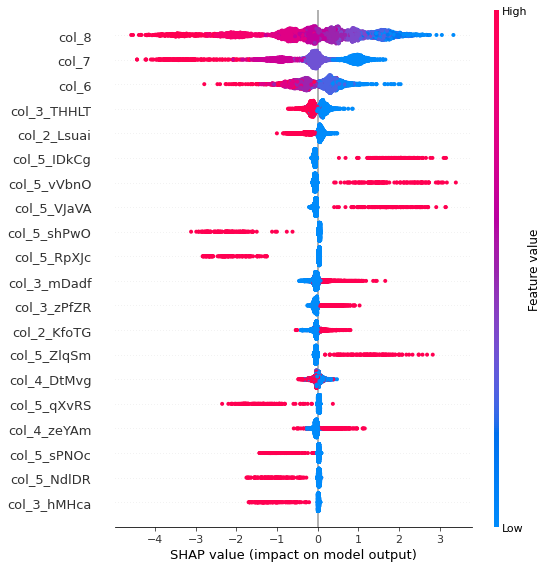

In [71]:
shap.summary_plot(shap_values, X_train)